# Calibration of GIWAXS Data with pyFAI in the Notebook

There's one part of every materials science workflow I know everybody loves: calibrating X-ray scattering area detector geometry! There are many reasons to look forward to this task:
* No single software package handles every special case
* No two beamlines use the same calibrant, detector, data file format, metadata encoding, spatial measurement conventions, etc.
* Calibrations can change multiple times during a single trip!
* Calibration was the last thing on your mind when you showed up to the beamline and wanted to start taking data

I am here to say... that these are mostly still unsolved problems. However, performing your calibration in a Jupyter notebook will at least bring some transparency to the process.

# Table of Contents <a name="contents"></a>
---

## [0. Loading Data](#data)
> ### [0.0 pandas, duh](#pandas)
> ### [0.1 Parsing Metadata](#meta)
> ### [0.2 I/O with `fabio`](#fabio)
> ### [0.3 Seeing Data](#imshow)

## [1. Calibration](#calib)
> ### [1.0 Detectors](#det)
> ### [1.1 Calibrants](#rings)
> ### [1.2 The Fitting Problem](#fitting)
> ### [1.3 Optimization in Python](#optim)

# 0. Loading Data <a name='data'></a>

Before we do anything else, let's take a look at the raw data we're working with.

## 0.0 pandas, duh <a name='pandas'></a>
---

[Back to TOC](#contents)

Just like the previous tutorial, we will use `pathlib` and `pandas` to traverse our data directory and make a table of the files we're working with.

In [88]:
from pathlib import Path
import pandas as pd

In [89]:
!ls data/NSLS-II/ # Probably won't work on Windows

WLI            calib          calib_saxs.csv ds30cn_30_s1
blanks         calib.csv      dpp_peaks.csv  ds30cn_30_w1


In the `data/NSLS-II/` directory, I have a few folders of interest for this tutorial: `calib`, `blanks`, and a couple of runs with actual data. Since we're calibrating for WAXS, let's first set up a DataFrame for our raw data, from the `ds30cn_30_w1/maxs` folder.

In [90]:
data_dir = Path('data/NSLS-II/ds30cn_30_w1/maxs/')
data_files = list(data_dir.glob('*.tiff'))
data_files[:5]

[PosixPath('data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000000_maxs.tiff'),
 PosixPath('data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000001_maxs.tiff'),
 PosixPath('data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000002_maxs.tiff'),
 PosixPath('data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000003_maxs.tiff'),
 PosixPath('data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000004_maxs.tiff')]

Our data is stored as .tiff files for this particular beamline. As you can see, most of the sample metadata is stored in the filename itself.

I'll call the DataFrame `dfd`, for "data". Since you access your dataframe a ton, you want it to be no more than 3 characters.

In [91]:
dfd = pd.DataFrame(data_files, columns=['path'])
dfd.tail()

path
905  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...
906  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...
907  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...
908  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...
909  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...

Let's get just the filenames as a column to start with.

In [92]:
dfd['name'] = dfd['path'].apply(lambda p: p.name)
dfd.head()

path  \
0  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
1  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
2  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
3  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
4  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   

                                                name  
0  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000000...  
1  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000001...  
2  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000002...  
3  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000003...  
4  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000004...

Man, those filenames are long! But they have a ton of metadata.

### We could break up the name with `str.split('_')`, but what if the parts change? (hint: they do for this data) In general, *positional rules for filename parsing are weak*.

Let's look at a few of these names up close.

In [95]:
print(dfd['name'].iloc[0])
print(dfd['name'].iloc[-1])

ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000000_maxs.tiff
ds30cn_30_w1_pos2_287.8s_th0.150_10.00s_994733_maxs.tiff


So these are the first and last image files. Having collected this data, I know it is from an *in situ* run where the first ~900 files are movie shots (collected quickly all in a row), and the last few are individual shots with longer exposures. There are some key differences:

* movie runs have a run stamp (994723) and a shot number (000000)
* individual shots have a position (pos2) and run stamp (994733)
* both have a run-start-time (92.8s, 287.8s), incident angle (th0.130, th0.150), and exposure time (0.10s, 10.00s)...

### We need to parse these out.

## 0.1 Parsing Metadata <a name='meta'></a>
---

[Back to TOC](#contents)

This step is annoying in any programming environment. It almost always requires writing new parsing functions and is highly tailored to each experiment and beamline.  You could re-arrange these files manually into their own folders (or with some clever UNIX scripts), but who wants to do that? You should be able to do this entirely within your analysis environment - and you can, with Python and pandas.

Ultimately, we want a DataFrame with columns for exposure time, theta, and maybe some other tags for every sample. This information is there for all our samples, we just have to grab it. pandas has great tools for this.

### Regular expressions - you knew it was coming

Pandas can do a lot with text data. [Read about it here](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html)

Let's say I just want exposure time, incident angle, and the run number - these are available for all samples. They have the following unique properties:
* Incident angle: looks like 'th[float]'
* Exposure time: looks like '[float]s' .. *but it's the second occurance of this*
* run number: first occurance of 6-digit int

Let's do incident angle first.

In [96]:
dfd['th'] = dfd['name'].str.extract(r"th([0-9]*\.[0-9]*)").astype(float)
dfd[:3]

path  \
0  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
1  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
2  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   

                                                name    th  
0  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000000...  0.13  
1  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000001...  0.13  
2  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000002...  0.13

`.str.extract(pattern)` accepts a regular expression and returns the first intance of the pattern matching group. Let's examine that in detail:
* `r""` is a *raw string*, meaning it won't treat the `\` as an escape character (it needs to be part of the regexp)
* `"th..."` we're looking for something starting with "th"
* `( ... )` is a matching group. The stuff that matches between the parens will be returned (so, not the "th")
* `[0-9]*` any number of integer characters
* `\.` a decimal point
* `[0-9]*` any number of integers again

Basically, we're looking for a float preceded by "th", and we want the float. Then we tack on `.astype(float)` to make it an actual float, not just a string. More on how to match floats [here](https://www.regular-expressions.info/floatingpoint.html).

### The clock and exposure times are more difficult because they're the same.

Both are float followed by "s". pandas has another method, `.str.extractall()`, that will return every occurance of a pattern match. But it returns the results as a DataFrame...

To match these, we just take the "th" away and add "s" to the end of our pattern:

In [97]:
dfd['name'].str.extractall(r"([0-9]*\.[0-9]*)s")[:6]

0
  match      
0 0      92.8
  1      0.10
1 0      92.8
  1      0.10
2 0      92.8
  1      0.10

The issue with `extractall` is that it gives us this MultiIndexed DataFrame. The first level is the original index from `dfd`, the second level is 'match', which has all the matches. The columns are for the case where I have multiple matching groups in the pattern (multiple sets of `()`), but I don't have that.

I want the 'match' index to be the columns, and to add those columns to `dfd` as `['clock']` and `['exp']`. That's called `.unstack()`

In [98]:
dfd['name'].str.extractall(r"([0-9]*\.[0-9]*)s").unstack()[0][:3]

match     0     1
0      92.8  0.10
1      92.8  0.10
2      92.8  0.10

Feel free to explore that a bit. The `[0]` is to get that column 0 seen above.

I'm not going to spell out how to extract each piece of metadata here; the point is that almost anything can be extracted in a single line with a regex or str method. Key points to remember:
* `.extract()` grabs only the first occurrance of your pattern in a string
* avoid absolute positional rules if you can, but sometimes they're the fastest
* `str.split()` can break up strings with separators like underscores, dashes, or spaces
* `str.strip()` can remove leading or trailing spaces
* remember to convert your new column to `int` or `float` with `.astype()` once you've gotten the numeric piece of the string - this is the true test of whether you extracted it correctly!

In [99]:
dfd[['clock', 'exp']] = dfd['name'].str.extractall(r"([0-9]*\.[0-9]*)s").unstack()[0].astype(float)
dfd['stamp'] = dfd['name'].str.extract(r"([0-9]{6})") # Grab the stamp while we're at it
dfd['pos'] = dfd['name'].str.extract(r"pos([0-9])") # Get position number (more on this later)
dfd['path'] = dfd['path'].astype(str) # This needs to happen eventually
dfd.head()

path  \
0  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
1  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
2  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
3  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   
4  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_92...   

                                                name    th  clock  exp  \
0  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000000...  0.13   92.8  0.1   
1  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000001...  0.13   92.8  0.1   
2  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000002...  0.13   92.8  0.1   
3  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000003...  0.13   92.8  0.1   
4  ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000004...  0.13   92.8  0.1   

    stamp  pos  
0  994723  NaN  
1  994723  NaN  
2  994723  NaN  
3  994723  NaN  
4  994723  NaN

### Believe it or not, that was a relatively pain-free metadata parsing process

This can get pretty complicated for some beamlines. Sometimes metadata is in a separate text file. pandas can handle that, too, and probably pretty elegantly. The end result is a table of your image files that's searchable by your metadata, and that's really powerful and not something other environments can offer.

## 0.2 I/O with `fabio` <a name='fabio'></a>
---

[Back to TOC](#contents)

At some point, you'd like to load and view your raw data, right? pyFAI recommends the [fabio](https://pythonhosted.org/fabio/api/modules.html#module-fabio.pilatusimage) library for this purpose. It's essentially an image i/o module for the file types commonly coming off of area detectors.

In [100]:
import fabio

I want to open the best looking pattern for this dataset. This is going to be one of the images from position 1 with the highest angle of incidence.

In [101]:
df_good = dfd[dfd.pos=='1'].sort_values('th', ascending=False)
df_good

path  \
904  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   
903  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   
902  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   
901  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   
900  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   

                                                  name    th  clock   exp  \
904  ds30cn_30_w1_pos1_272.8s_th0.150_10.00s_994732...  0.15  272.8  10.0   
903  ds30cn_30_w1_pos1_241.8s_th0.120_10.00s_994730...  0.12  241.8  10.0   
902  ds30cn_30_w1_pos1_210.8s_th0.100_10.00s_994728...  0.10  210.8  10.0   
901  ds30cn_30_w1_pos1_179.8s_th0.080_10.00s_994726...  0.08  179.8  10.0   
900  ds30cn_30_w1_pos1_147.8s_th0.050_10.00s_994724...  0.05  147.8  10.0   

      stamp pos  
904  994732   1  
903  994730   1  
902  994728   1  
901  994726   1  
900  994724   1

Indeed - I would like the first row, there. So I'll grab that path and open it!

In [102]:
img = fabio.open(df_good['path'].iloc[0])
img

Fabio throws warnings *all the damn time*. I have never had an actual issue. "Bogus stripBytes count" is another fun one. Feel free to explore other .tif i/o modules - I have no particular reason for using this one other than it was recommended and it works. Apparently it's robust to many different types of detector images. Again, I've found this to be true.

The fabio module has lots of functionality. `.data` is basically the only attribute we'll ever access, though.

In [103]:
img.data

array([[ 155,  130,  137, ...,  178,  176,  217],
       [ 116,  114,  125, ...,  177,  157,  202],
       [ 142,  132,  107, ...,  173,  149,  190],
       ...,
       [  70,   52,   44, ...,  716,  848, 1001],
       [  70,   39,   52, ...,  728,  839,  922],
       [  63,   57,   57, ...,  801,  891, 1037]], dtype=int32)

That's our image array! I want to look at that. Looks like we're already at the next section.

## 0.3 Seeing Data <a name='imshow'></a>
[Back to TOC](#contents)

Not much to say here. Same old %magic and matplotlib imports to start things off.

In [104]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'Arial',
                 'font.size': 12,
                 'savefig.dpi': 300,
                 'figure.dpi': 96
                })
import numpy as np

In [105]:
# %config InlineBackend.figure_format = 'retina' # Comment this line out if your monitor is 1080p or less
%matplotlib notebook

### Raw scattering data frequently has extreme outlier values.

So we need to pass some limits for the colorscale of `plt.imshow()`, specifically `vmin` and `vmax`. It's useful to compute these with `np.percentile()` - note the `(0.5, 99.8)` indicating the 0.5 and 99.8th percentiles of img.data.

In [106]:
img.data.max() # Take a look at this

230171

<IPython.core.display.Javascript object>


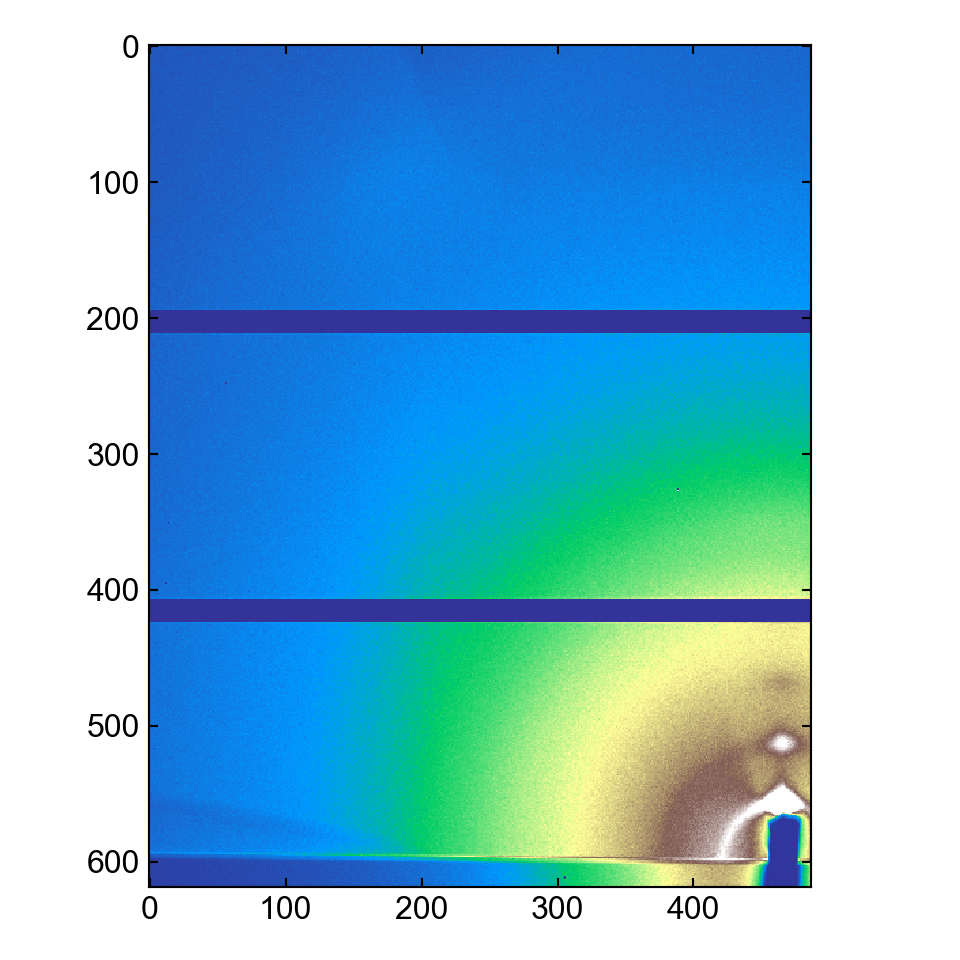

In [107]:
plt.figure(figsize=(5,5))
vmin, vmax = np.percentile(img.data, (0.5, 99.8))
plt.imshow(img.data, cmap='terrain', vmin=vmin, vmax=vmax)

`plt.imshow()` is meant for showing images. It ensures your x/y aspect ratio is 'equal', and it plots the array as it is, with y-indices increasing downward and x-indices increasing left-to-right.

### This happens often enough that I have a function for it

Here, I'm making it so you can just pass the path of an image, it opens it, makes it log-scale if you want, sets the color scale to the percentiles you want, and shows the image. If you just pass a path, it does all of this with good default values.

I have `ax` as a kwarg incase you want to make a grid of such plots - we'll see this in a bit. You can pass an `Axes` object to plot onto, or if you don't, it makes the new `Figure` for you. For any plotting function you write, it is almost always a good idea to have an option `ax` argument like this.

In [110]:
def show_img(path, ax=None, prcs=(0.5, 99.8), log=False,
             cmap='terrain', aspect='equal', figsize=(5,5),
             extent=None, origin=None):
    
    if ax is None:   # If no axis was passed, make a new figure
        fig, ax = plt.subplots(figsize=figsize)
        
    img = fabio.open(path).data   # Load data from path
        
    if log:             # If user wants log, clip the img array to min. of 1
        img = np.log(np.clip(img, 1, None)) # need to avoid taking log(0)
    
    vmin, vmax = np.percentile(img, prcs)   # Set min and max for color scale with percentiles
        
    ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax,
              extent=extent, aspect=aspect, origin=origin)   # pass thru the kwargs for imshow

<IPython.core.display.Javascript object>


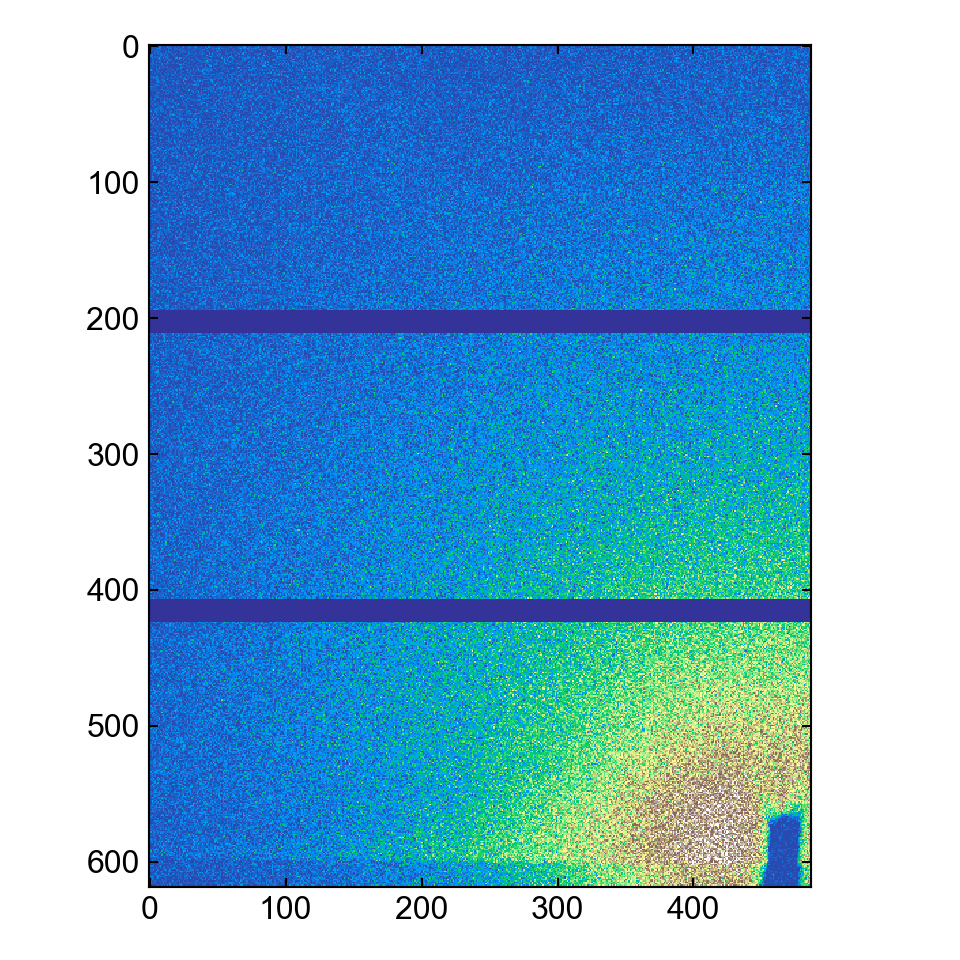

In [111]:
show_img(dfd.path[0])

### What if I want to look at multiple images at once?

Remember df_good? That was an angle of incidence series (AOI Series) for this sample. What if I want to see all of those images at once? Here we will start to glimpse how powerful pandas makes us.

In [112]:
df_good

path  \
904  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   
903  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   
902  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   
901  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   
900  data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_po...   

                                                  name    th  clock   exp  \
904  ds30cn_30_w1_pos1_272.8s_th0.150_10.00s_994732...  0.15  272.8  10.0   
903  ds30cn_30_w1_pos1_241.8s_th0.120_10.00s_994730...  0.12  241.8  10.0   
902  ds30cn_30_w1_pos1_210.8s_th0.100_10.00s_994728...  0.10  210.8  10.0   
901  ds30cn_30_w1_pos1_179.8s_th0.080_10.00s_994726...  0.08  179.8  10.0   
900  ds30cn_30_w1_pos1_147.8s_th0.050_10.00s_994724...  0.05  147.8  10.0   

      stamp pos  
904  994732   1  
903  994730   1  
902  994728   1  
901  994726   1  
900  994724   1

pandas allows us to iterate over the rows of a DataFrame with `.iterrows()`. This will return `(index, row)` for each row. We can access any of the columns of the row within each iteration of the for loop:

In [113]:
for ind, row in df_good.iterrows():
    print(ind, row['path'])

904 data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_pos1_272.8s_th0.150_10.00s_994732_maxs.tiff
903 data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_pos1_241.8s_th0.120_10.00s_994730_maxs.tiff
902 data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_pos1_210.8s_th0.100_10.00s_994728_maxs.tiff
901 data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_pos1_179.8s_th0.080_10.00s_994726_maxs.tiff
900 data/NSLS-II/ds30cn_30_w1/maxs/ds30cn_30_w1_pos1_147.8s_th0.050_10.00s_994724_maxs.tiff


Looks like a Series the way I did that, but the point is at each iteration, I have access to the index and all of the columns of each row.

The next thing we need to understand is how `plt.subplots()` works. When I call this function, it returns a `Figure`, and an `Array` of `Axes`:

<IPython.core.display.Javascript object>


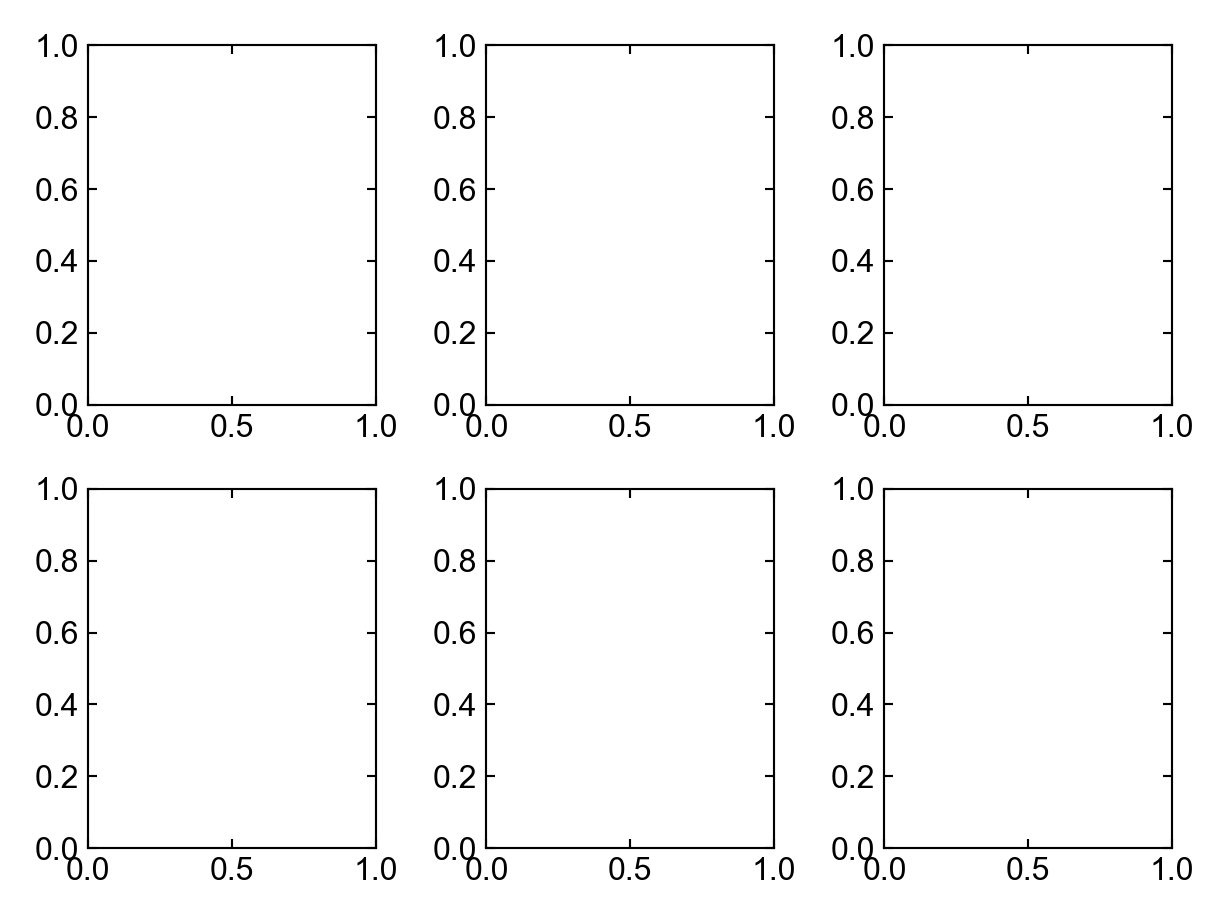

In [114]:
fig, axes = plt.subplots(2,3)

In [24]:
print(axes.shape)
axes

(2, 3)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1140f5f60>,
      dtype=object)

That's a 2x3 `Array`, unsurprisingly. What if I wanted to iterate over that as well? For loops will iterate over the rows of a Numpy Array, so the `axes` Array needs to be 1-D for this to work. `.ravel()` strings an N-D Array out into a 1-D Array.

In [115]:
print('Original:')
print(np.array([[0, 1, 2], [3, 4, 5]]))
print('raveled:')
print(np.array([[0, 1, 2], [3, 4, 5]]).ravel())

Original:
[[0 1 2]
 [3 4 5]]
raveled:
[0 1 2 3 4 5]


In [116]:
axes.ravel()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1329ec0b8>,
      dtype=object)

Ok, now I can iterate over the `Axes` from `plt.subplots()`.

Now what if I want to iterate over `axes` *and* `df_good` *simultaneously*?? This is what `zip()` is for:

<IPython.core.display.Javascript object>


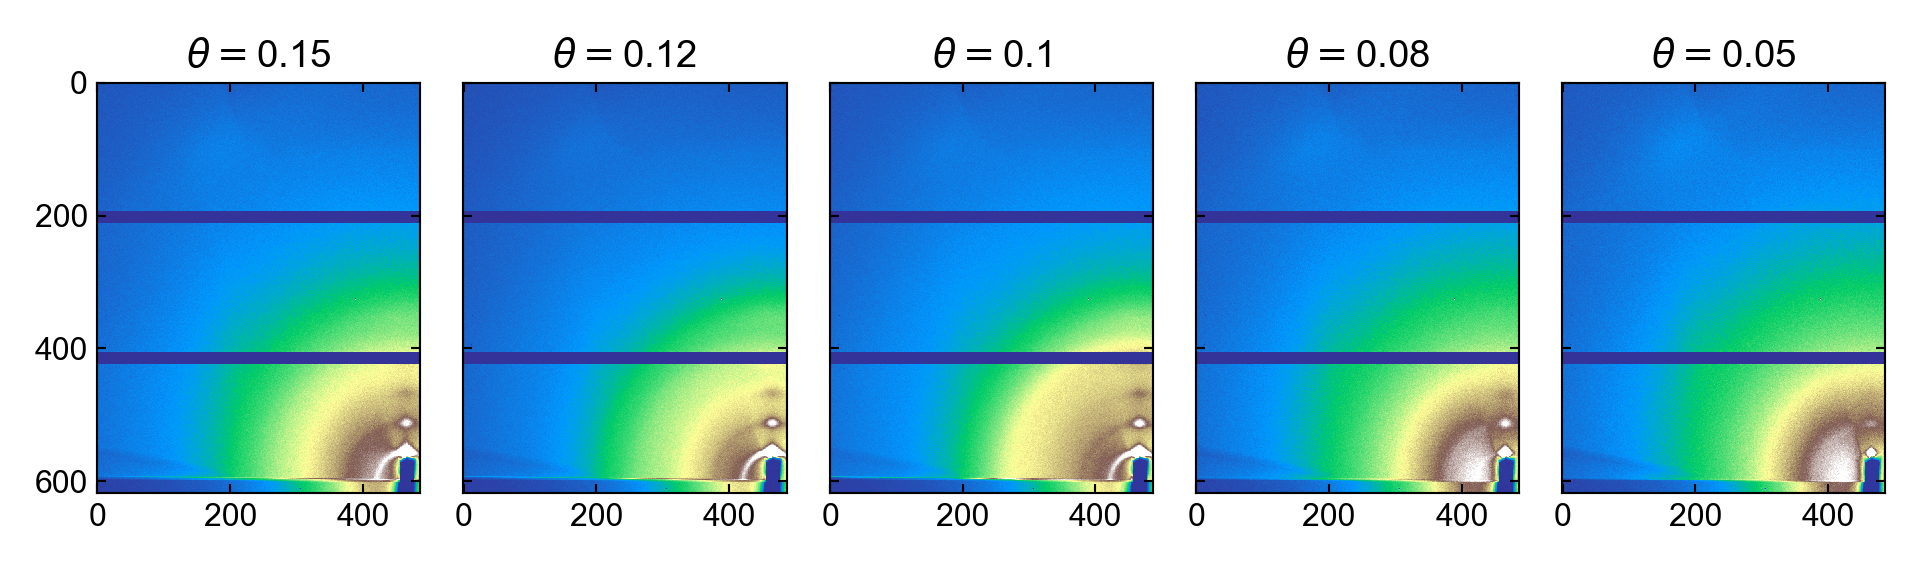

In [117]:
# Set up one row of subplots with num_columns = rows in df_good
fig, axes = plt.subplots(1, len(df_good), figsize=(10,3), sharex=True, sharey=True)

# zip the axes and the rows of df_good, then do whatever we want!
for ax, (ind,row) in zip(axes.ravel(), df_good.iterrows()):
    show_img(row['path'], ax=ax)
    ax.set_title(r'$\theta = ${}'.format(row['th']))

If we set things up correctly, we can search our data and generate useful visualizations with *very few* lines of code.

That's nice, and will be applicable later, but we came here to calibrate. No more delay!

# 1. Calibration <a name='calib'></a>

Analysis of X-ray scattering patterns, once properly calibrated, is a rich subject in and of itself, with plenty of literature available. But calibrating an scattering pattern transformation (pixel space to momentum transfer space) is a rich subject *without* plenty of literature available.

### The meat of the problem is the following question: where was my detector relative to my sample?

## 1.0 Detectors <a name='det'></a>
---
[Back to TOC](#contents)

Answering this question requires a library that understands the geometry of detectors. [PyFAI](https://pyfai.readthedocs.io/en/latest/) is a remarkably fully-featured, GPU-compute-optimized library for the calibration, reduction and analysis of X-ray scattering patterns from many different detectors and modes. Over the coming tutorials, we will learn its innerworkings and examine practical use cases.

![pyfai](images/pyfai_geometry.png)

### From the [pyFAI documentation](https://pyfai.readthedocs.io/en/latest/geometry.html):

>With the detector being a rigid body, its position in space is described by six parameters: 3 translations and 3 rotations. In pyFAI, the beam center is not directly used as it is ill-defined with highly tilted detectors. Like SPD, we use the orthogonal projection of origin on the detector surface called PONI (for Point Of Normal Incidence). For non planar detectors, the PONI is defined in the plan z=0 in detector’s coordinate system.

>Poni1 and Poni2 are distances in meter (along the y and x axis of the detector), like the sample-detector distance, letting the calibration parameters be independent of the pixel size hence stable regarding the binning factor of the detector.

>In the same idea rot1, rot2 and rot3 are rotation along axis 1, 2 and 3, always expressed in radians. Rotations applied in the same order: rot1 then rot2 and finally rot3. Due to the axial symmetry of the Debye-Scherrer cones, rot3 cannot be optimized but can be adjusted manually in some cases like if the detector is not mounted horizontally and/or one cares about polarization correction.

### In pyFAI, an area detector is defined by its pixel width and height.

It actually has a number of detectors built-in!

In [118]:
import pyFAI
pyFAI.detectors.Pilatus300k()

Detector Pilatus 300k	 PixelSize= 1.720e-04, 1.720e-04 m

Looks like the Pilatus 300k has pixels that are $172 \times 172 \:\mu m$. For non-standard detectors, you can enter pixel size yourself:

In [119]:
pyFAI.detectors.Detector(100e-6,100e-6)

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m

### OK, we're done!

### Just kidding - now comes the hard part.

As seen in the image above, there are a few other parameters that we need to determine:
* energy / wavelength: this should have been provided by your beamline, or available in sample metadata
* `rot1`, `rot2`, `rot3`: detector rotations - your beamline may have provided these
* `PONI1`, `PONI2`: these are **NOT necessarily** the beam center - see above. PONI = Point of Normal Incidence. In the case where rot1=rot2=0, they may be equivalent. These will be fitted quantities.
* Sample-detector distance: the distance from the sample to the PONI. You should have a good guess for this, but it will also be fit.

### I'd like to stress that this is a *fitting* problem.

The calibration is a function that converts your raw image into a corrected image with corresponding axes in $q_{xy}$ and $q_z$. Your goal is to obtain this calibration. The parameters above are fitted model parameters, and the objective of the fitting procedure is to get a fake calibrant pattern to match the real one you collected. Some calibration tools will simplify this by fitting ring peaks, but these simplifications usually rule out more complicated detector geometries, and furthermore, add extra layers of data transformation that increase the likelihood of errors.

Here, we will take what I believe to be the most general (and visually intuitive) approach possible.

## 1.1 Calibrants <a name='rings'></a>
---
[Back to TOC](#contents)

pyFAI also contains a number of built-in calibrants. This means that it knows the peak locations in inverse space for a given calibrant material, and can simulate scattering patterns for that material and a given set of detector parameters.

In [120]:
from pyFAI import calibrant
pyFAI.calibrant.ALL_CALIBRANTS

Calibrants available: AgBh, Al, alpha_Al2O3, Au, C14H30O, CeO2, Cr2O3, cristobaltite, CrOx, CuO, LaB6, LaB6_SRM660a, LaB6_SRM660b, LaB6_SRM660c, mock, NaCl, Ni, PBBA, quartz, Si, Si_SRM640, Si_SRM640a, Si_SRM640b, Si_SRM640c, Si_SRM640d, Si_SRM640e, TiO2, ZnO

In [121]:
agbh = pyFAI.calibrant.get_calibrant('AgBh')
agbh.dSpacing[:5]

[58.38, 29.19, 19.46, 14.595, 11.676]

### We will need to give our calibrant a wavelength before it can do anything useful.

In [122]:
Energy = 12 #keV... I just knew this.
wl = 3e8 * 6.63e-34 / Energy * 6.242e15 # c*h/Energy * keV/Joule = wavelength in meters
print('Wavelength =', wl, 'meters')
agbh._wavelength = wl   # Store the wavelength in the calibrant

Wavelength = 1.0346114999999999e-10 meters


### Now it can generate fake images; but we need the real ones to compare!

So now we will generate a DataFrame, `dfc`, for the calibration images, using a process very similar to `dfd`. This time, I can skip the explanation and show just how compact the code is for the data ingestion process.

I am copy-pasting most of this from the process above. Note that in Command Mode in Jupyter (press <kbd>Esc</kbd>), <kbd>f</kbd> will bring up a find/replace window, from which I can find `dfd` and replace with `dfc`.

In [123]:
# Get files and start the DataFrame
calib_files = list(Path('data/NSLS-II/calib/').glob('*.tiff'))
dfc = pd.DataFrame({'path': calib_files})
dfc['name'] = dfc['path'].apply(lambda p: p.name)
dfc['path'] = dfc['path'].astype(str)

dfc.head()

path  \
0  data/NSLS-II/calib/AgBH_cali_12kev_106.1s_th0....   
1  data/NSLS-II/calib/AgBH_cali_12kev_120.1s_th0....   
2  data/NSLS-II/calib/AgBH_cali_12kev_148.1s_th0....   
3  data/NSLS-II/calib/AgBH_cali_12kev_157.1s_th0....   
4  data/NSLS-II/calib/AgBH_cali_12kev_170.1s_th0....   

                                                name  
0  AgBH_cali_12kev_106.1s_th0.171_1.00s_994875_sa...  
1  AgBH_cali_12kev_120.1s_th0.171_1.00s_994876_sa...  
2  AgBH_cali_12kev_148.1s_th0.171_1.00s_994877_sa...  
3  AgBH_cali_12kev_157.1s_th0.171_1.00s_994878_sa...  
4  AgBH_cali_12kev_170.1s_th0.171_5.00s_994879_sa...

In [124]:
# Grab that juicy metadata
dfc['th'] = dfc['name'].str.extract(r"th([0-9]*\.[0-9]*)").astype(float)
dfc[['clock', 'exp']] = dfc['name'].str.extractall(r"([0-9]*\.[0-9]*)s").unstack()[0].astype(float)
dfc['stamp'] = dfc['name'].str.extract(r"([0-9]{6})") # Grab the stamp while we're at it
dfc['en'] = dfc['name'].str.extract(r"([0-9]*)kev").astype(float)  # Look at that, we've got energies
dfc['mode'] = dfc['name'].str.extract(r"_([A-Za-z]+).tiff")

dfc[dfc['mode']=='maxs']

path  \
5   data/NSLS-II/calib/AgBH_cali_12kev_185.2s_th0....   
10  data/NSLS-II/calib/AgBH_cali_17.0keV_2.8m_103....   
11  data/NSLS-II/calib/AgBH_cali_17.0keV_2.8m_138....   
14  data/NSLS-II/calib/AgBH_cali_17.0keV_2.8m_67.1...   
15  data/NSLS-II/calib/AgBH_cali_17.0keV_2.8m_76.1...   

                                                 name     th  clock   exp  \
5   AgBH_cali_12kev_185.2s_th0.171_5.00s_994880_ma...  0.171  185.2   5.0   
10  AgBH_cali_17.0keV_2.8m_103.2s_th0.175_1.00s_99...  0.175  103.2   1.0   
11  AgBH_cali_17.0keV_2.8m_138.1s_th0.175_10.00s_9...  0.175  138.1  10.0   
14  AgBH_cali_17.0keV_2.8m_67.1s_th0.175_1.00s_993...  0.175   67.1   1.0   
15  AgBH_cali_17.0keV_2.8m_76.1s_th0.175_1.00s_993...  0.175   76.1   1.0   

     stamp    en  mode  
5   994880  12.0  maxs  
10  993892   NaN  maxs  
11  993893   NaN  maxs  
14  993890   NaN  maxs  
15  993891   NaN  maxs

So looking back on that "parsing metadata" section, there was a lot of explanation, but in the end we did all of this database construction in 10 lines. That's nuts. Honestly we don't even need most of this stuff, but we just get it for free because we built up these tools with our raw data.

We need a calibration in the 'maxs' mode at 12keV. Looks like there's one with 5s exposure at index 5.

<IPython.core.display.Javascript object>


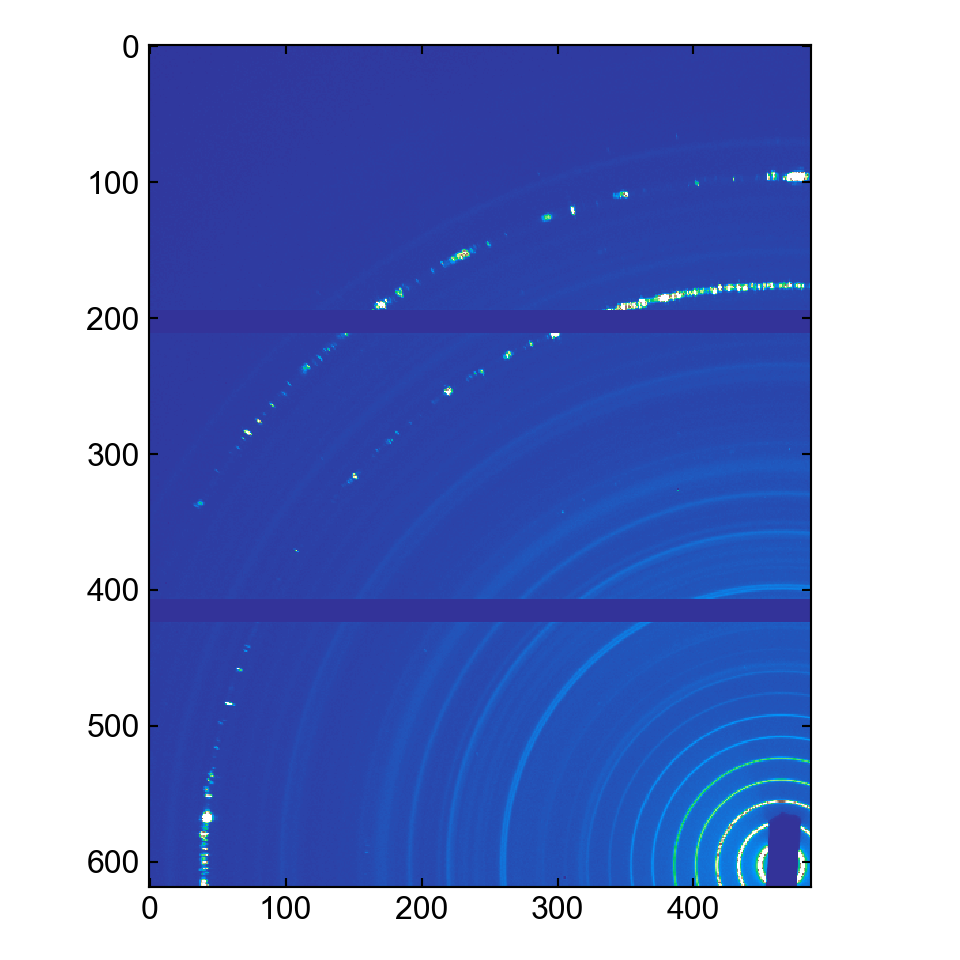

In [125]:
show_img(dfc.loc[5,'path'])

### That's the real calibration image; to generate a fake, we need to guess the detector params.

The one we can get from the image above is the PONI. Remember, with no detector tilt this should be the same as the beam center. Because I'm using `%matplotlib notebook`, I can hover my mouse over the center of the rings and see `x=463, y=603`. This means the approximate PONI is at Array indices [603, 463].

We will store all of these parameters in a dict, because they will soon get passed to a pyFAI object.

In [126]:
param_dict = {}

### From above
center_guess = [603, 466] # in pixel indices [y from top, x from left]

### Sample-detector distance (measure at beamline)
param_dict['dist'] = 0.15  # in meters

### Energy and Wavelength
Energy = 12 #keV... See table above
wl = 3e8 * 6.63e-34 / Energy * 6.242e15 # c*h/Energy * keV/Joule = wavelength in meters
param_dict['wavelength'] = wl

### Detector pixel size
det_pix = [172e-6, 172e-6] # We could have loaded the Pilatus, but this is easy enough
param_dict['detector'] = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

### Convert center_guess into meters (pixel location * meters/pixel)
param_dict['poni1'] = center_guess[0]*det_pix[0]
param_dict['poni2'] = center_guess[1]*det_pix[1]

### Enter detector rotations (see figure above), if any
param_dict['rot1'] = 0    /180 * np.pi # move detector to right, in-plane angle in radians
param_dict['rot2'] = 0    /180 * np.pi # move detector up, out-of-plane angle
param_dict['rot3'] = 0    /180 * np.pi # clockwise rotation

param_dict

{'dist': 0.15,
 'wavelength': 1.0346114999999999e-10,
 'detector': Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m,
 'poni1': 0.103716,
 'poni2': 0.080152,
 'rot1': 0.0,
 'rot2': 0.0,
 'rot3': 0.0}

### Given these parameter guesses (that's all of them), we can now produce a fake image from our calibrant.

Let's re-define the calibrant here to alleviate scrolling.

In [127]:
agbh = pyFAI.calibrant.get_calibrant('AgBh')
agbh._wavelength = wl   # Store the wavelength in the calibrant
agbh

AgBh Calibrant at wavelength 1.0346114999999999e-10

### For pyFAI to generate an image, we need to define an "`AzimuthalIntegrator`"

This performs the necessary geometric transformations to make an image on the hypothetical detector we've defined by the parameter guesses. It's the central class in the pyFAI library, but we won't get into that now. We just pass the param_dict as *kwargs for this class.

We also need to know the shape of our image array.

The fake is an image array, so we can plot it with `plt.imshow()`. Using our bag of matplotlib tricks, we can show the fake and the real side-by-side.

<IPython.core.display.Javascript object>


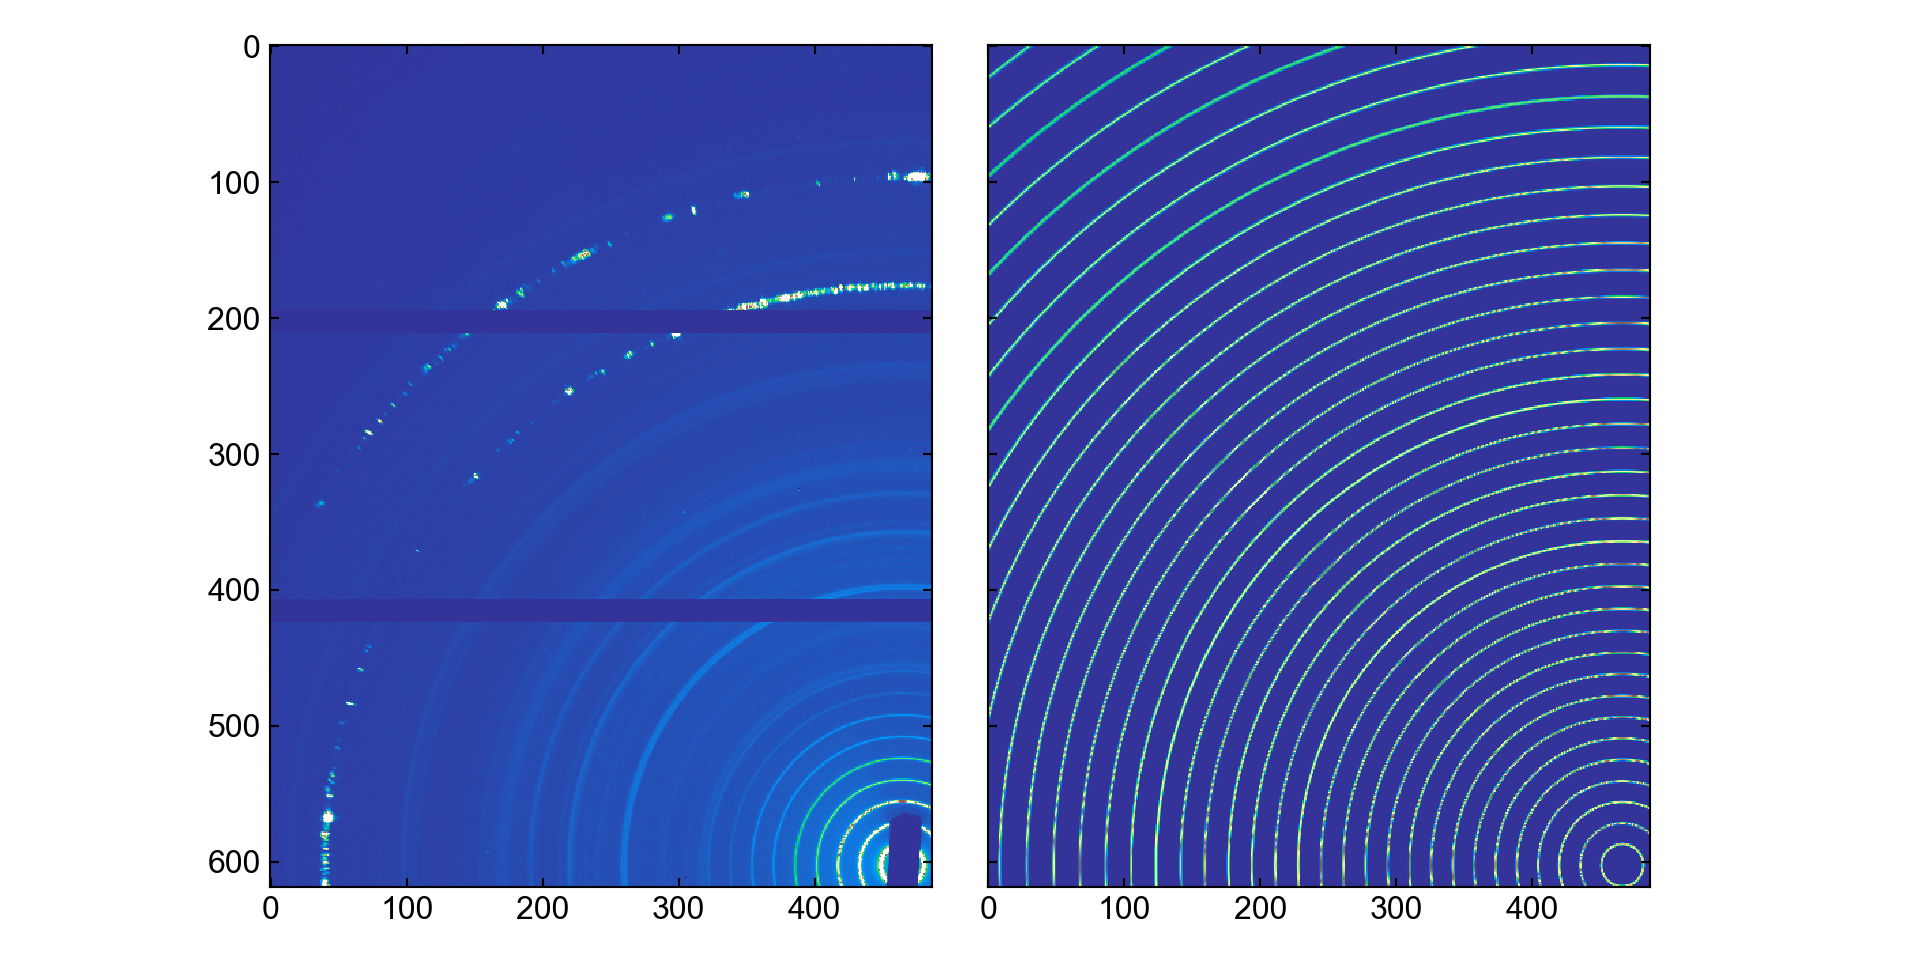

In [128]:
ai = pyFAI.AzimuthalIntegrator(**param_dict)
image_shape = fabio.open(dfc.loc[5,'path']).data.shape
fake = agbh.fake_calibration_image(ai, shape = image_shape, W=1e-6) # W changes the width of the peaks

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
show_img(dfc.loc[5,'path'], ax=axes[0])  # Plot real image
axes[1].imshow(fake, cmap='terrain')     # Plot fake image

### COOL. Now let's talk about how to turn this into an optimization problem.

## 1.2 The Fitting Problem <a name='fitting'></a>
---
[Back to TOC](#contents)

Like I said earlier, finding a good calibration is a fitting problem. We want to adjust:
* sample-detector distance
* PONI1 and PONI2
* Possibly rot1, rot2

until our fake and real rings overlap. Let's take a look at that cell with the side-by-side plots again, but this time with the adjustable parameters within sight. Try changing some of the parameters to see how it affects the fake image.

### Finally, use the zoom-box tool to zoom in on a region where both the real and fake images have clear rings with no detector artifacts (bars, beamstop and the like).

In [129]:
param_dict = {}

### From above
center_guess = [603, 466] # in pixel indices [y from top, x from left]

### Sample-detector distance (measure at beamline)
param_dict['dist'] = 0.15  # in meters

### Energy and Wavelength
Energy = 12 #keV... See table above
wl = 3e8 * 6.63e-34 / Energy * 6.242e15 # c*h/Energy * keV/Joule = wavelength in meters
param_dict['wavelength'] = wl

### Detector pixel size
det_pix = [172e-6, 172e-6] # We could have loaded the Pilatus, but this is easy enough
param_dict['detector'] = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

### Convert center_guess into meters (pixel location * meters/pixel)
param_dict['poni1'] = center_guess[0]*det_pix[0]
param_dict['poni2'] = center_guess[1]*det_pix[1]

### Enter detector rotations (see figure above), if any
param_dict['rot1'] = 0    /180 * np.pi # move detector to right, in-plane angle in radians
param_dict['rot2'] = 0    /180 * np.pi # move detector up, out-of-plane angle
param_dict['rot3'] = 0    /180 * np.pi # clockwise rotation

<IPython.core.display.Javascript object>


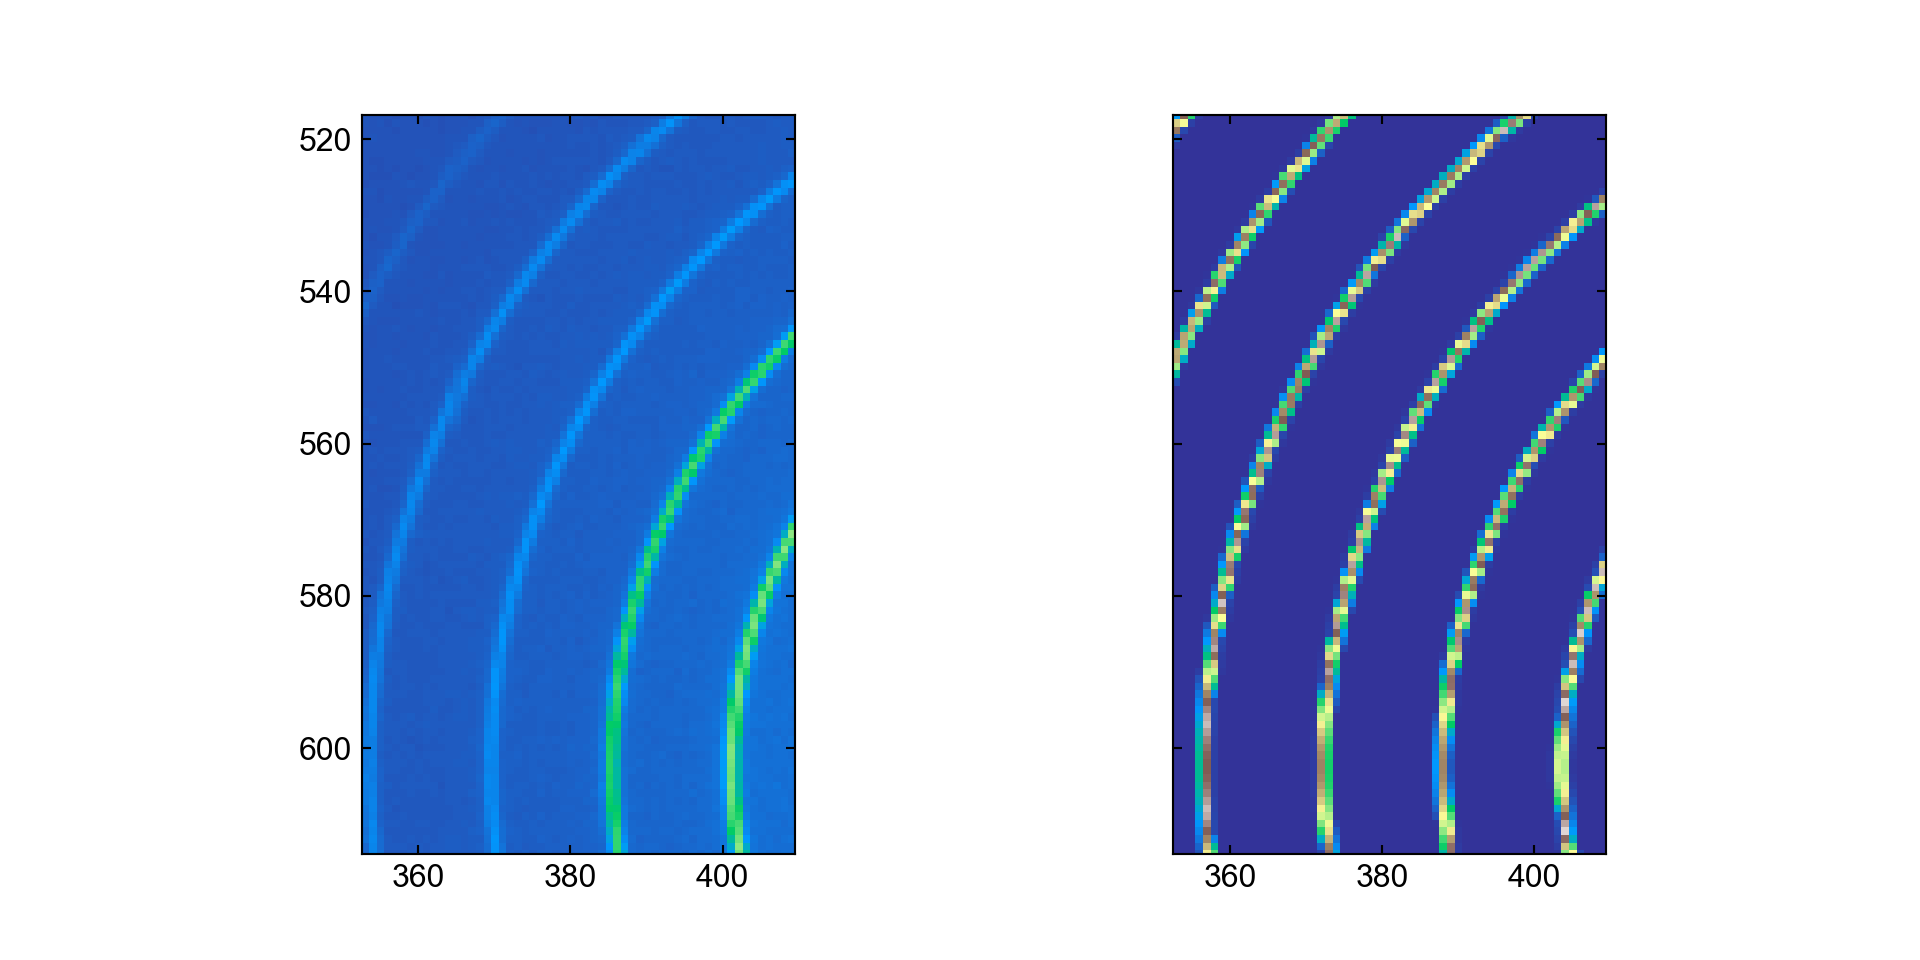

In [145]:
agbh = pyFAI.calibrant.get_calibrant('AgBh')
agbh._wavelength = wl   # Store the wavelength in the calibrant

ai = pyFAI.AzimuthalIntegrator(**param_dict)
image_shape = fabio.open(dfc.loc[5,'path']).data.shape
fake = agbh.fake_calibration_image(ai, shape = image_shape, W=1e-6) # W changes the width of the peaks

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True, tight_layout=False)
show_img(dfc.loc[5,'path'], ax=axes[0])  # Plot real image
axes[1].imshow(fake, cmap='terrain')     # Plot fake image

### This is called an ROI: Region of Interest.

We want to select an ROI where there are at least 2 visible rings, and where the rings have a good amount of curvature. The cool part about `%matplotlib notebook` is that after using the zoom-box tool to select an ROI, I can just grab the current axis limits using `.get_xlim()` or `.get_ylim()`. In this way, interactive matplotlib figures are great tools for selecting an ROI.

In [146]:
xl = np.round(axes[0].get_xlim()).astype(int)
yl = np.round(axes[0].get_ylim()).astype(int)[::-1]  # Gotta reverse this because it's backwards
print(xl, yl)

[353 409] [517 614]


### We have our ROI, but now we want to maximize the "overlap" of these images

Every optimization problem needs a scalar-valued objective function. In this case, that's going to be the absolute difference in pixel intensities between the real and fake images, taken over all pixels.

There's just one problem: the scale of pixel intensities is vastly different for both images. We should standardize that for both. Let's explore that a bit.

In [147]:
real = fabio.open(dfc.loc[5, 'path']).data

print(fake.min(), fake.max())
print(real.min(), real.max())

0.0 0.9749502695052602
-1 445933


Whoa, that's rough. Even if we consider just the ROI for both, it looks like fake varies from 0 to 1, while real varies from hundreds to thousands.

In [148]:
fake_roi = fake[yl[0]:yl[1], xl[0]:xl[1]]
real_roi = real[yl[0]:yl[1], xl[0]:xl[1]]

print(fake_roi.min(), fake_roi.max())
print(real_roi.min(), real_roi.max())

4.355984069055239e-87 0.9128984186422245
570 5041


Let's try standardizing each (zero-mean, unit-variance). These intensities are not normally-distributed, but this should work pretty well.

In [149]:
fake_roi_std = (fake_roi - np.mean(fake_roi)) / np.std(fake_roi)
real_roi_std = (real_roi - np.mean(real_roi)) / np.std(real_roi)

print(fake_roi_std.min(), fake_roi_std.max())
print(real_roi_std.min(), real_roi_std.max())

print('Mean diff:', np.mean(np.abs(fake_roi_std-real_roi_std), axis=(0,1)))

-0.3558561326969679 5.033778317427206
-0.809259130111363 6.932389766938426
Mean diff: 0.7873509223154136


### So our objective function is to minimize the mean absolute difference (Mean Absolute Error) between the real and fake calibration images after cropping to an ROI and standardizing intensities.

This is a good Obj. Fun. because it should be scaled well between 0-1. Let's write a plotting function to visualize the objective, which will plot the real ROI, the fake ROI, and the magnitude of the difference between them.

In [150]:
def ofun_viz(real, fake, axes=None, err=None):
    
    if axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True)
    
    [ax.images.clear() for ax in axes] # Remove existing images so they don't accumulate
    
    err_array = np.abs(real-fake)
    axes[0].imshow(real, cmap='terrain')  # plot real image
    axes[1].imshow(fake, cmap='terrain')  # plot fake image
    axes[2].imshow(err_array, cmap='Reds')
    
    if err is None:
        err = np.mean(err_array, axis=(0,1))
    
    [a.set_title(t) for a,t in zip(axes, ['real', 'fake', 'err={}'.format(np.round(err,4))])]
    # Using a list comprehension to do things

<IPython.core.display.Javascript object>


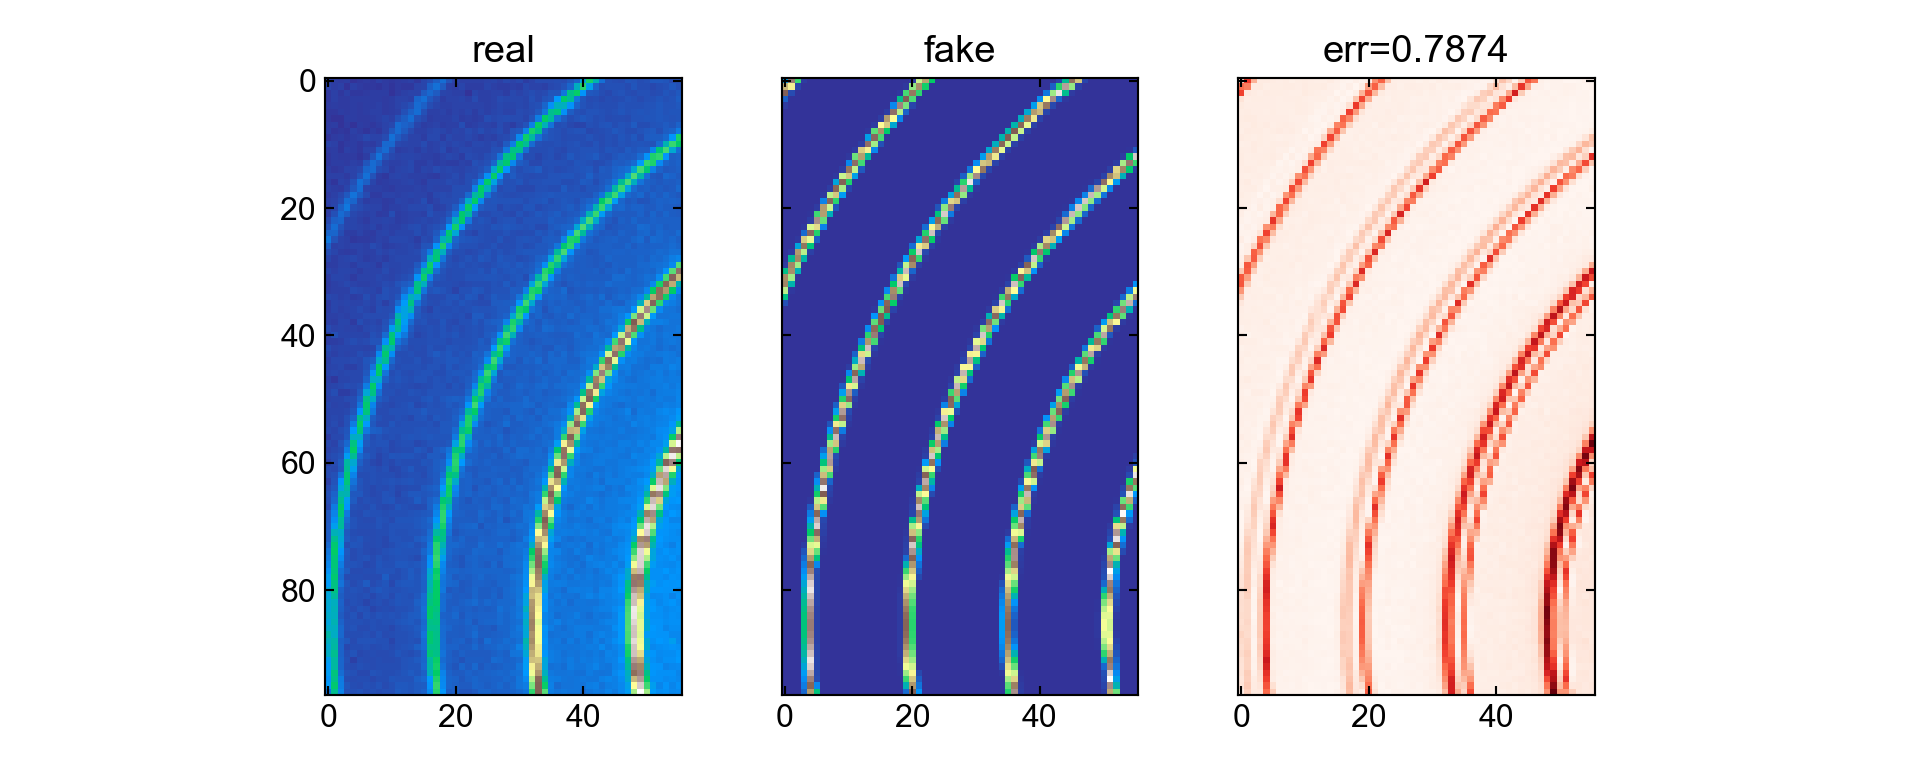

In [151]:
ofun_viz(real_roi_std, fake_roi_std)

The first ring (if it's visible) is generally very strong. I try to avoid putting the first ring in the optimization for this reason: it dominates the error term. However, this should still work. It's time to optimize.

## 1.3 Optimization in Python <a name='optim'></a>
---
[Back to TOC](#contents)

Crash course on optimization:
* You have an objective function that returns a scalar (preferably scaled between 0-1 with 0 being the target value)
* The objective function has adjustable parameters that you vary to affect the scalar output
* Optimization algorithms explore different values of the parameters to find the lowest value of the scalar output

Here, we will use [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) - not the most powerful or fully-featured optimization library in history, but this should be a well-behaved convex function with a small search space (*i.e.* we have good initial guesses), so it'll be fine.

In [152]:
from scipy.optimize import minimize

### First, we have to define our objective function.

Generally, optimization libraries like the objective function to be in the form:

$f(X, other\:constant\:params...)$

where X is a vector containing the adjustable parameters: X will contain `[dist, poni1, poni2]`. I want a function that takes my current param_dict, writes an objective function, optimizes it, and gives me back the best param_dict. The inputs will be:

* param_dict
* the path to the real calibration image
* the calibrant
* (optionally) a list of `Axes` to plot the results in real-time
* (optionally) the x- and y-limits defining the ROI

And the output will be a `dict` with the same keys as `param_dict`, but with updated optimal values.

In [153]:
param_dict

{'dist': 0.15,
 'wavelength': 1.0346114999999999e-10,
 'detector': Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m,
 'poni1': 0.103716,
 'poni2': 0.080152,
 'rot1': 0.0,
 'rot2': 0.0,
 'rot3': 0.0}

### This cell breaks all my rules

In [158]:
def optimize_calibration(param_dict, real_calib_path, calibrant,
                         varied=['dist','poni1','poni2'],
                         axes=None, xl=[0,-1], yl=[0,-1], W=1e-6):
    
    # We want to do as much outside the obj_fun as possible (to minimize time per call)
    real = fabio.open(real_calib_path).data  # Open the real calibration image
    real_roi = real[yl[0]:yl[1], xl[0]:xl[1]]  # Crop to the ROI
    real_roi_std = (real_roi - np.mean(real_roi)) / np.std(real_roi)  # Standardize

    
    # Here we use an "inner function" to create our objective function
    def obj_fun(x, varied, param_dict_fixed):
        
        param_dict_varied = {k:v for k,v in zip(varied, x)} # Rebuild 'x' into arguments for the AI
        param_dict_full = {**param_dict_varied, **param_dict_fixed}  # This needs >=python3.5 I believe
        
        ai = pyFAI.AzimuthalIntegrator(**param_dict_full)  # Spin up the Azimuthal Integrator
        fake = agbh.fake_calibration_image(ai, shape = real.shape, W=W)  # Generate the fake image
        fake_roi = fake[yl[0]:yl[1], xl[0]:xl[1]]  # Crop to ROI
        fake_roi_std = (fake_roi - np.mean(fake_roi)) / np.std(fake_roi)  # Standardize
        
        err = np.mean(np.abs(fake_roi_std-real_roi_std), axis=(0,1))  # Calculate MAE
#         print('Residual: ', err)
        
        # Show results if we passed 'axes'
        if axes is not None:
            ofun_viz(real_roi_std, fake_roi_std, axes=axes, err=err)
            axes[0].figure.canvas.draw()
            plt.pause(0.2)
            
        return err
    
    
    # scipy.minimize needs an initial guess, so we take the 'varied' values of param_dict
    varied_params_init = [param_dict[k] for k in varied]  # Get just the values of the varied params
    param_dict_fixed = {k:v for k,v in param_dict.items() if k not in varied}  # dict.items() iterates through the key,value pairs
    args = (varied, param_dict_fixed)  # This needs to be the non-x arguments to obj_fun

    x_opt = minimize(obj_fun, varied_params_init,
                     args=args, method='nelder-mead', tol=1e-3,
                     options={'disp':True,
                              'maxiter':1000})
    
    param_dict_varied = {k:v for k,v in zip(varied, x_opt['x'])} # Rebuild 'x' into arguments for the AI
    final_param_dict = {**param_dict_varied, **param_dict_fixed}
    
    return final_param_dict

### Take some time to digest that.

There are a lot of advanced Python tricks there, like `dict` comprehensions, `**kwargs`, and inner functions. I made this really flexible for teaching purposes, and as a kind of challenge for myslef - it's not often that you write an optimization algorithm that updates an outside data visualization at every eval, or that can vary the number of parameters that it varies. I've tried to comment each line so it's clear what's going on.

But now, the cool part.

<IPython.core.display.Javascript object>


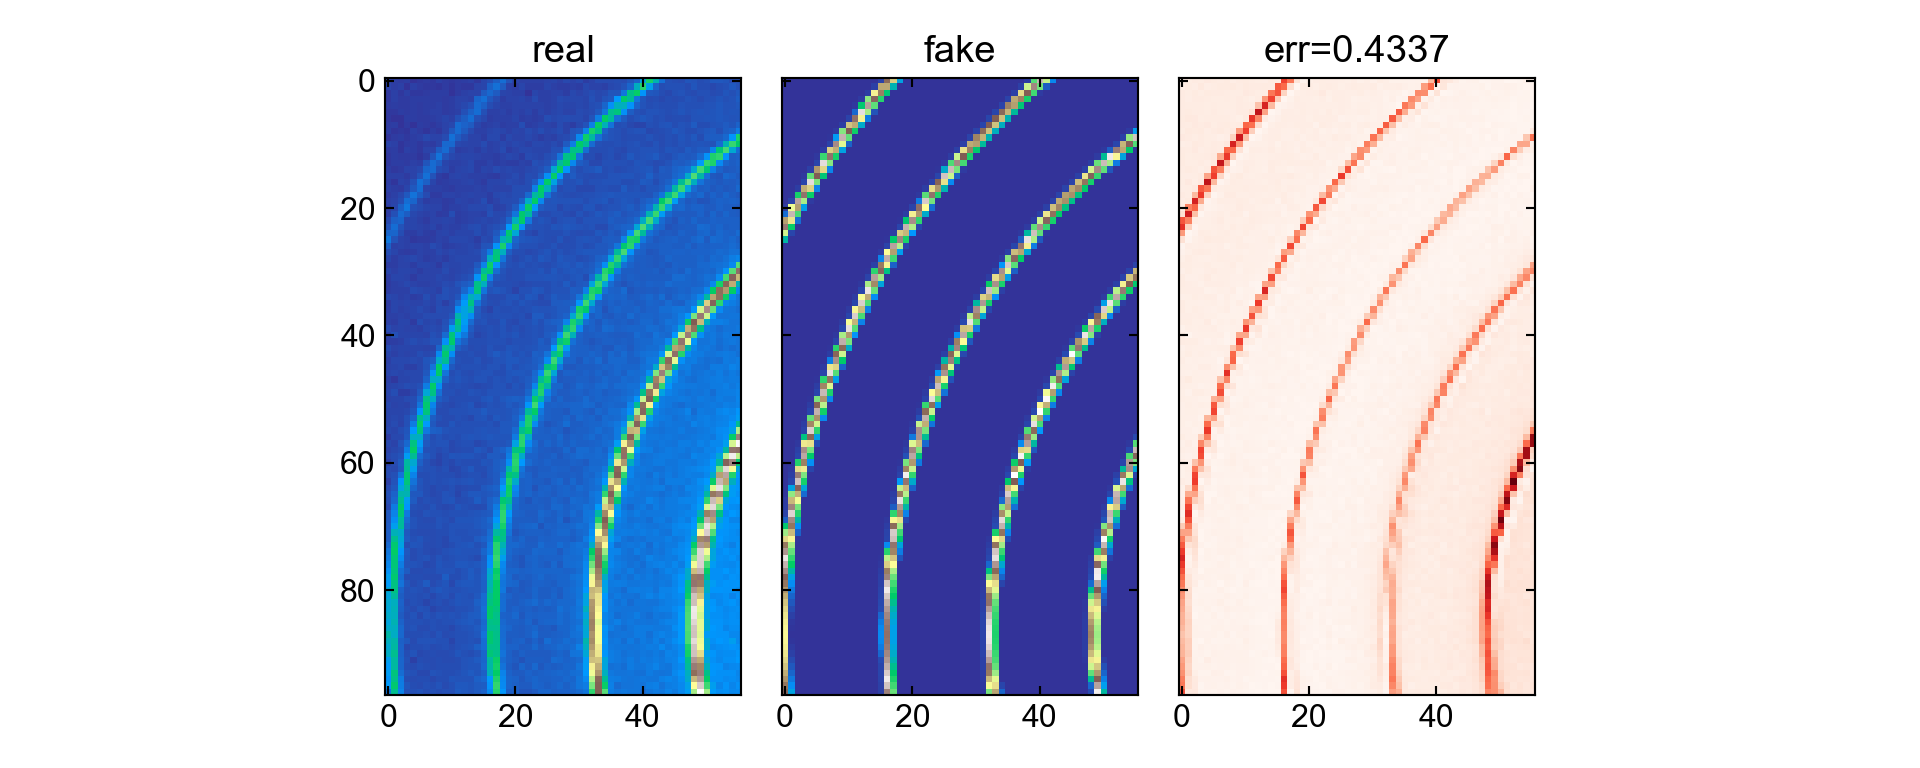

In [161]:
fig, axes = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True)

In [162]:
final_param_dict = \
    optimize_calibration(param_dict, dfc.loc[5, 'path'], agbh,
                         varied=['dist','poni1','poni2'],
                         axes=axes, xl=xl, yl=yl)

Optimization terminated successfully.
         Current function value: 0.432978
         Iterations: 56
         Function evaluations: 102


In [163]:
final_param_dict

{'dist': 0.15630315837286365,
 'poni1': 0.10396922035878745,
 'poni2': 0.08023796615533921,
 'wavelength': 1.0346114999999999e-10,
 'detector': Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m,
 'rot1': 0.0,
 'rot2': 0.0,
 'rot3': 0.0}

### Import python libraries

In [170]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# numpy and plotting
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'DejaVu Sans'
                })

from ipywidgets import interact

# Data handling
import glob
import os
import pandas as pd

# pyFAI
import pyFAI
from pyFAI.calibrant import get_calibrant
# from pyFAI.gui import jupyter

# pygix
import pygix
import fabio
from pygix import plotting as ppl

# Peak Fitting, optimization
from lmfit.models import GaussianModel, LorentzianModel, ExponentialModel, ConstantModel, LinearModel, VoigtModel
from scipy.optimize import minimize
from scipy.signal import medfilt

from nsls_utils_air import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data files and dark spectra files

In [174]:
# data_dir = "\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\data\\NSLS-II CMS data\\2018-Dec\\Nils\\dead_vac"
nils_dir = "/Users/nils/CC/CMS Data/Nils/insitu_air"
sample_name = 'ds30cn_30_w1'
waxs_dir = os.path.join(nils_dir, sample_name, 'maxs')
waxs_files = glob.glob(os.path.join(waxs_dir, '*.tiff'))
print(waxs_files[0])

/Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn_30_w1/maxs/ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000000_maxs.tiff


## Master dataframe for actual data files

In [175]:
### build_master_table does a bunch of filename parsing in the background
dfw = build_master_table(waxs_files)
dfw.head()

tiff  burst  exp_time  mode  \
0  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    0.0       0.1  maxs   
1  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    1.0       0.1  maxs   
2  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    2.0       0.1  maxs   
3  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    3.0       0.1  maxs   
4  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    4.0       0.1  maxs   

         sample   stamp     t  theta  
0  ds30cn_30_w1  994723  92.8   0.13  
1  ds30cn_30_w1  994723  92.8   0.13  
2  ds30cn_30_w1  994723  92.8   0.13  
3  ds30cn_30_w1  994723  92.8   0.13  
4  ds30cn_30_w1  994723  92.8   0.13

## Dataframe for calibration files

In [176]:
# data_dir = "\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\data\\NSLS-II CMS data\\2018-Dec\\Nils\\dead_vac"
calib_dir = "/Users/nils/CC/CMS Data/Nils/insitu_air/calib"
calib_files = glob.glob(os.path.join(calib_dir, '*.tiff'))
print(calib_files[0])
dfc = build_master_table(calib_files)
dfc['det'] = dfc['tiff'].apply(lambda s: os.path.basename(s).split('_')[-1].split('.')[0])
dfc

/Users/nils/CC/CMS Data/Nils/insitu_air/calib/AgBH_cali_12kev_106.1s_th0.171_1.00s_994875_saxs.tiff


tiff                  sample  \
0   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
1   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
2   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
3   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
4   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
5   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
6   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
7   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
8   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
9   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
10  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
11  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
12  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
13  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
14  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
15  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   

        t  theta  exp_time   stamp  mode   det  
0   106.1  0.171       1.0  994875  saxs  saxs  
1   120.1  0.171       1.0  994876  saxs  saxs  
2   148.1  0.171       1.0  994877  saxs  saxs  
3   157.1  0.171       1.0  994878  saxs  saxs  
4   170.1  0.171       5.0  994879  saxs  saxs  
5   185.2  0.171       5.0  994880  maxs  maxs  
6    28.1  0.171       1.0  994871  saxs  saxs  
7    63.2  0.171       1.0  994872  saxs  saxs  
8    71.2  0.171       1.0  994873  saxs  saxs  
9    85.3  0.171       1.0  994874  saxs  saxs  
10  103.2  0.175       1.0  993892  maxs  maxs  
11  138.1  0.175      10.0  993893  maxs  maxs  
12  167.1  0.175      10.0  993894  saxs  saxs  
13  408.2  0.000      10.0  993895  saxs  saxs  
14   67.1  0.175       1.0  993890  maxs  maxs  
15   76.1  0.175       1.0  993891  maxs  maxs

## Calibration

In [177]:
calib_data = fabio.open(dfc.loc[5].tiff).data
calib_data.shape

2019-02-26 08:00:07,463 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


(619, 487)

<IPython.core.display.Javascript object>


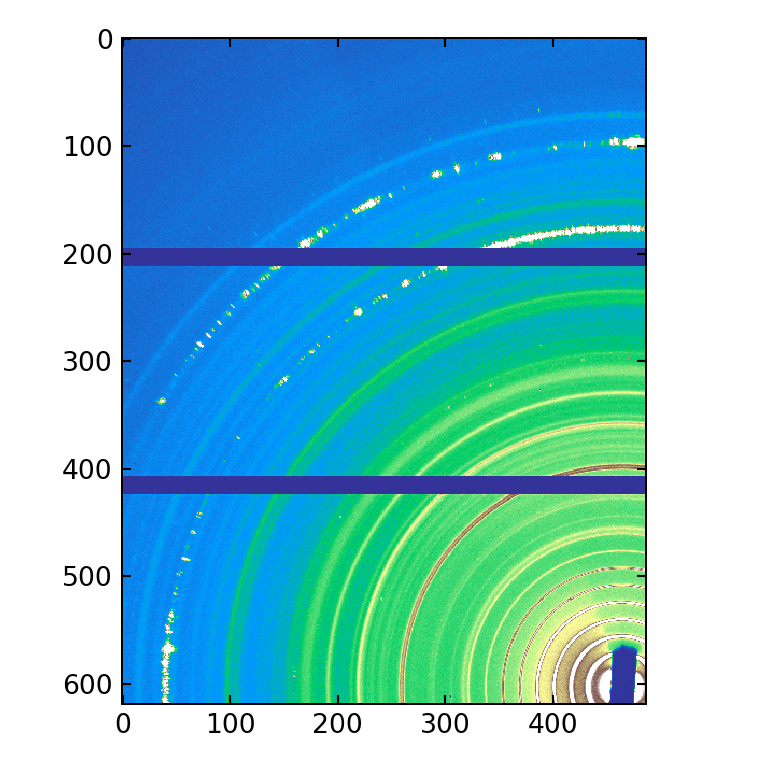

In [178]:
%matplotlib notebook

# det_shape = (619,487)

lmin, lmax = np.percentile(calib_data, (2, 99))
plt.figure(figsize=(4,4))
plt.imshow(calib_data, cmap='terrain',
           vmin=lmin, vmax=lmax,
           origin='upper')

### Beam center looks like [466, 603]

In [179]:
# NSLS-II is a photon Science CCD
# 17 keV for this calib image apparently
# nominally 190 mm

### Starting beam position
sdd_guess = 0.153
center_guess = [603, 466] # -y, +x

### Detector pixel size
det_pix = [172e-6, 172e-6]
detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

### Wavelength
Energy = 12 #keV
wl = 3e8 * 6.63e-34 / Energy * 6.242e15 # c*h/Energy * keV/Joule = wavelength in meters

### Silver whatever calibrant
agbh = get_calibrant('AgBh')
agbh._wavelength = wl
vars(agbh)

{'_filename': '/anaconda/envs/pygix/lib/python3.6/site-packages/pyFAI/utils/../resources/calibration/AgBh.D',
 '_wavelength': 1.0346114999999999e-10,
 '_sem': <threading.Semaphore at 0x134e2ef28>,
 '_2th': [],
 '_dSpacing': []}

## Compare real calibration image to fake one

<IPython.core.display.Javascript object>


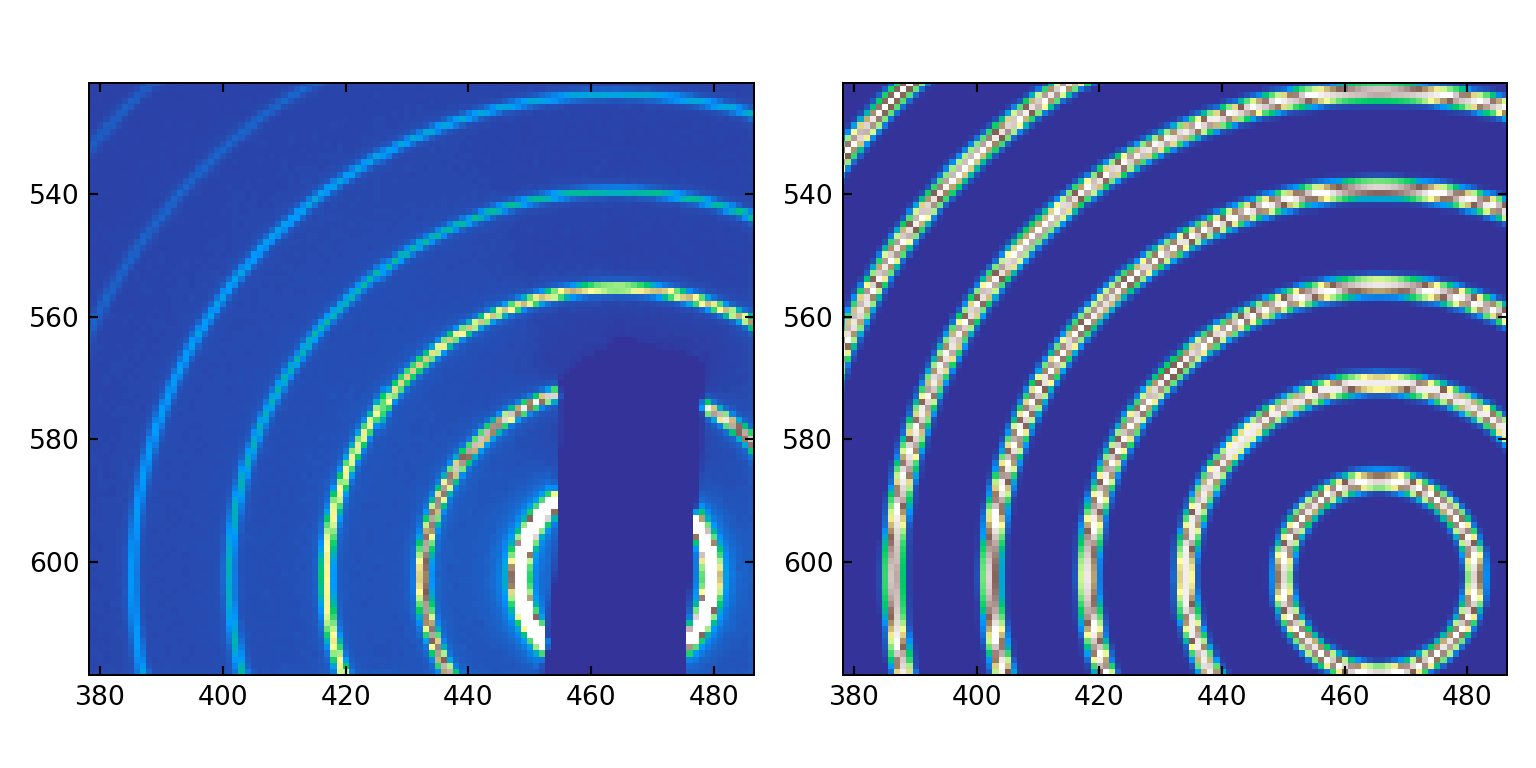

In [180]:
### Give initial guess of center location (in meters from the image origin i.e top left)
poni1_guess = center_guess[0]*det_pix[0]
poni2_guess = center_guess[1]*det_pix[1]

rot1 = 0    /180 * np.pi # move detector to right, in-plane angle# in radians
rot2 = 0    /180 * np.pi # move detector up, out-of-plane angle
rot3 = 0    /180 * np.pi # clockwise rotation

### Have to define an "azi integrator" then it can generate fake image of the calibrant
ai = pyFAI.AzimuthalIntegrator(dist=sdd_guess, poni1=poni1_guess, poni2=poni2_guess,
                               rot1=rot1, rot2=rot2, rot3=rot3,
                               detector=detector, wavelength=wl)
fake = agbh.fake_calibration_image(ai, shape = calib_data.shape, W=0.000005)

### Plot the real calibration image next to fake one
cmin, cmax = np.percentile(fake, (2, 99.9))
lmin, lmax = np.percentile(calib_data, (10, 99.9))

plt.figure(figsize=(8,4))
ax1=plt.subplot(122)
plt.imshow(fake, cmap='terrain',
           vmin=cmin, vmax=cmax,
           origin='upper')
ax2=plt.subplot(121, sharex=ax1, sharey=ax1)
plt.imshow(calib_data, cmap='terrain',
           vmin=lmin, vmax=lmax,
           origin='upper')
# plt.savefig('calib_debug\\rings.png')

## Write down coordinates of mask by zooming in on a ring section with a flat-ish background

In [181]:
mask_bounds = [525,575,390,440] # indices of a box around a ring sector: [i-, i+, j-, j+]
fg_int=8000; bg_int=1000 # approximate ring intensity, approximate bg intensity - read from graph above
fake_ring_int = 0.9; fake_bg_int = 0
scale_init = [(fg_int-bg_int)/(fake_ring_int-fake_bg_int), bg_int-(fg_int-bg_int)/(fake_ring_int-fake_bg_int)*fake_bg_int]

In [182]:
scale_init

[7777.777777777777, 1000.0]

## Define an optimizer that will fit a fake ring to a real ring
Looks like we should target the first ring, so we need to define mask bounds so we don't try to fit every ring

In [184]:
from datetime import datetime

def calib_obj_fun(x, calib_img, detector, calibrant, bb, wl, scale, W, rot1, rot2, rot3):
    
    # x: [beam_cent_y, beam_cent_x, sdd, fake_scale]
    # bb is mask bounds [-i, +i, -j, +j]
#     print(x.shape)
    
    # Set up test detector
    det_shape=calib_img.shape
    poni1 = x[0]*detector.get_pixel1()
    poni2 = x[1]*detector.get_pixel2()
    ai = pyFAI.AzimuthalIntegrator(dist=x[2], poni1=poni1, poni2=poni2,
                                   rot1=x[3], rot2=x[4], rot3=rot3,
                                   detector=detector, wavelength=wl)
    
    # Generate fake calibrant image, apply scale and background
    fake = calibrant.fake_calibration_image(ai, shape = det_shape, W=W) * scale[0] + scale[1]

    # Return the sum of the ABSOLUTE difference
    out = np.sum(np.sum(np.abs(calib_img-fake)[bb[0]:bb[1],bb[2]:bb[3]]))
    print('Residual: {}'.format(out))
    return out

def calibrate_waxs(calib_img, detector, calibrant, cent_init, sdd_init, scale_init, wl, mask_bounds,
                   rot1, rot2, rot3, W=0.000005):
    
    init_params = [cent_init[0], cent_init[1], sdd_init, rot1, rot2]
    
    args = (calib_img, detector, calibrant, mask_bounds, wl, scale_init, W, rot1, rot2, rot3)

    final_params = minimize(calib_obj_fun, init_params,
                            args=args, method='nelder-mead', tol=1e-3,
                            options={'disp':True,
                                     'maxiter':1000})
    
    return final_params

In [185]:
det_params = calibrate_waxs(calib_data, detector, agbh, center_guess, sdd_guess, scale_init, wl, mask_bounds,
                            rot1, rot2, rot3)
det_params

Residual: 2127581.6379787647
Residual: 3713080.841240162
Residual: 3205108.9478041288
Residual: 3450813.3142229393
Residual: 2066314.6346239785
Residual: 2195856.0162911825
Residual: 3212125.728126965
Residual: 3582382.5245143976
Residual: 2509461.0807264876
Residual: 3735978.0367388204
Residual: 3285768.1281793118
Residual: 2093454.4276951544
Residual: 2118199.8921410604
Residual: 2131756.6028361483
Residual: 3707869.439560118
Residual: 3544083.583919305
Residual: 3679812.928162992
Residual: 3717551.9709701436
Residual: 2079261.4862225447
Residual: 2089967.0968251922
Residual: 2032908.9232767234
Residual: 3340390.8688339395
Residual: 3649298.6185769793
Residual: 3744247.6840257193
Residual: 3091988.380199587
Residual: 3697517.58369999
Residual: 2680353.935518212
Residual: 3161479.98958458
Residual: 2501191.905634217
Residual: 3383491.8002712494
Residual: 2151184.30794113
Residual: 2030477.6392935633
Residual: 2610788.9775789124
Residual: 2273479.1602028883
Residual: 1989666.0634123648

 final_simplex: (array([[6.03317955e+02, 4.64537373e+02, 1.52394811e-01, 2.33302778e-04,
        3.42113209e-05],
       [6.03317952e+02, 4.64537369e+02, 1.52394808e-01, 2.33301575e-04,
        3.42095019e-05],
       [6.03317951e+02, 4.64537368e+02, 1.52394802e-01, 2.33301343e-04,
        3.42095274e-05],
       [6.03317955e+02, 4.64537366e+02, 1.52394809e-01, 2.33301382e-04,
        3.42093528e-05],
       [6.03317950e+02, 4.64537370e+02, 1.52394808e-01, 2.33301069e-04,
        3.42088527e-05],
       [6.03317953e+02, 4.64537367e+02, 1.52394801e-01, 2.33301547e-04,
        3.42099528e-05]]), array([1948266.24754824, 1948266.24775662, 1948266.24788332,
       1948266.24797092, 1948266.24834257, 1948266.24845458]))
           fun: 1948266.247548245
       message: 'Optimization terminated successfully.'
          nfev: 282
           nit: 146
        status: 0
       success: True
             x: array([6.03317955e+02, 4.64537373e+02, 1.52394811e-01, 2.33302778e-04,
       3.42113209e-

## Finally, build a detector based on the fitted parameters

In [186]:
dfw.loc[904]

tiff        /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...
burst                                                     NaN
exp_time                                                   10
mode                                                     maxs
sample                                      ds30cn_30_w1_pos1
stamp                                                  994732
t                                                       272.8
theta                                                    0.15
Name: 904, dtype: object

## Try a transform, see how it works

2019-02-26 08:03:47,098 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


<IPython.core.display.Javascript object>


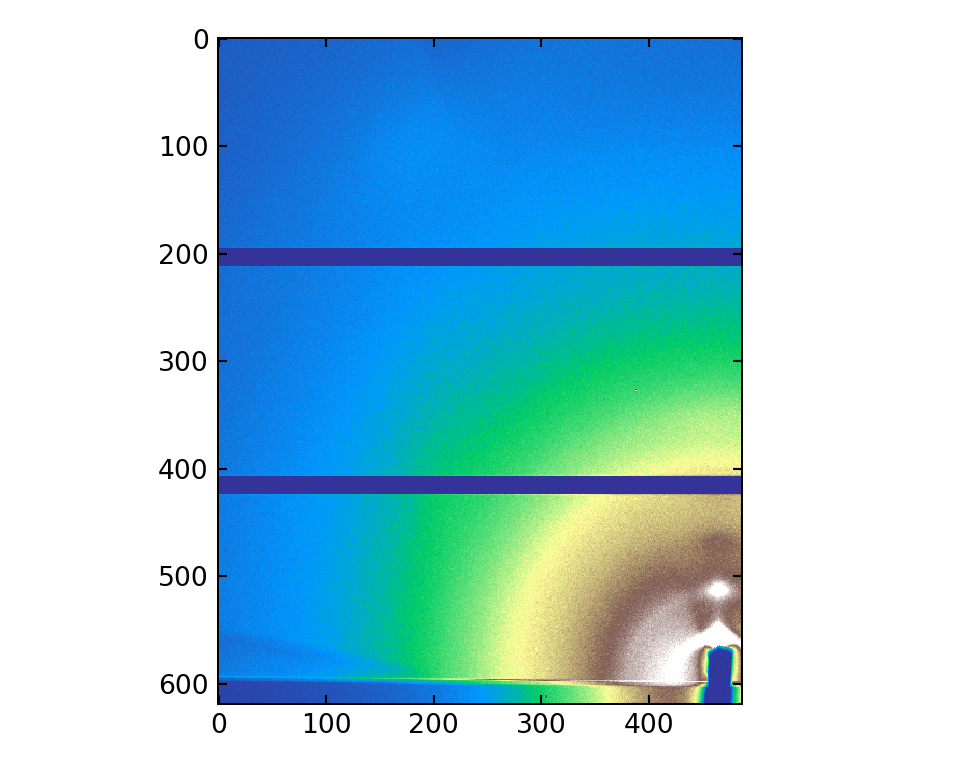

In [187]:
sample = 904

pcolor(get_data(dfw,sample), aspect='equal')

## Dump detector params to a csv

In [188]:
# Orientations and Angles
sample_orientation = 1    # 1 is horizontal, 2 is vertical
tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")

### poni1 is the y-coordinate (in meters) on the detector where the beam hits.
### poni2 is same for x. So we take the fitted beam center in pixels and multiply by the pixel size
det_param_dict = {'det_pix': det_pix[0],
                  'wavelength': wl,
                  'poni1': det_params.x[0] * det_pix[0],
                  'poni2': det_params.x[1] * det_pix[1],
                  'dist': det_params.x[2],
                  'rot1': det_params.x[3],
                  'rot2': det_params.x[4],
                  'rot3': 180 / 180 *np.pi,
                  'sample_orientation': sample_orientation,
                  'tilt_angle': tilt_angle}

det_param_df = pd.DataFrame(det_param_dict, index=['val']).transpose().reset_index().rename(columns={'index':'param'})
det_param_df.to_csv(os.path.join(nils_dir,'calib.csv'))

In [189]:
det_param_df = pd.read_csv(os.path.join(nils_dir,'calib.csv'))
det_kwargs = dict(zip(det_param_df['param'], det_param_df['val']))
det_kwargs

{'det_pix': 0.000172,
 'dist': 0.1523948111643043,
 'poni1': 0.10377068826819774,
 'poni2': 0.07990042810956673,
 'rot1': 0.000233302777589545,
 'rot2': 3.421132088879312e-05,
 'rot3': 3.1415926535897927,
 'sample_orientation': 1.0,
 'tilt_angle': 0.0,
 'wavelength': 1.0346115e-10}

2019-02-26 08:04:01,288 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:04:01,341 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:04:01,402 - pygix.transform - INFO - pygix.Transform.transform_image: Resetting transformer because init


<IPython.core.display.Javascript object>


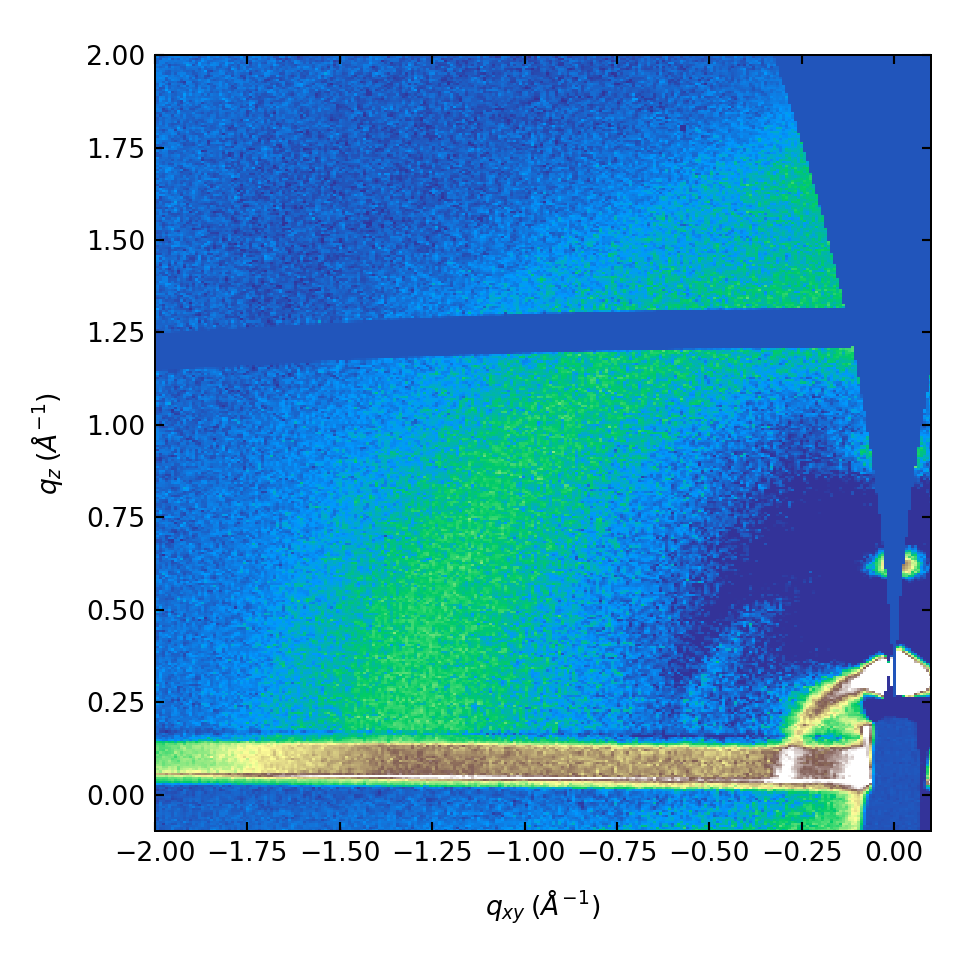

/anaconda/envs/pygix/lib/python3.6/site-packages/pygix-0.1.4a0-py3.6.egg/pygix/plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


(<matplotlib.image.AxesImage at 0x13082ce10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13958b588>)

In [190]:
pg = setup_detector(dfw['theta'].loc[sample], os.path.join(nils_dir,'calib.csv'))
imgt, qxy, qz = pg.transform_reciprocal(get_data(dfw,sample), method='lut',
                                        correctSolidAngle=True, unit='A',
                                        dark=get_blank(dfb, dfw, sample, blank_set='test_si'))
corrimg = imgt-np.min(imgt)+1
logimg = np.log(corrimg)

clim = np.percentile(logimg[logimg>1], (2, 99.8))
plt.figure(figsize=(5,5))
ppl.implot(logimg, qxy, qz, mode='rsma',
           cmap="terrain", clim=clim,
           xlim=(-2,0.1), ylim=(-0.1,2),
           newfig=False)

In [191]:
def get_pole_figure(df, sample, calib_csv, chi_range=(-90,0), q_range=(0,2), npt=(180,180)):
    
    data = get_data(df, sample)
    theta = df.loc[sample].theta
    pg = setup_detector(theta, calib_csv)
    print(data.shape)
    
    intensity, q_abs, chi = pg.transform_polar(data, unit='A',
                                               npt=npt,
                                               chi_range=chi_range, q_range=q_range,
                                               correctSolidAngle=True,
                                               method='splitpix')
    
    return intensity, q_abs, chi

2019-02-26 08:04:20,224 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


(619, 487)


<IPython.core.display.Javascript object>


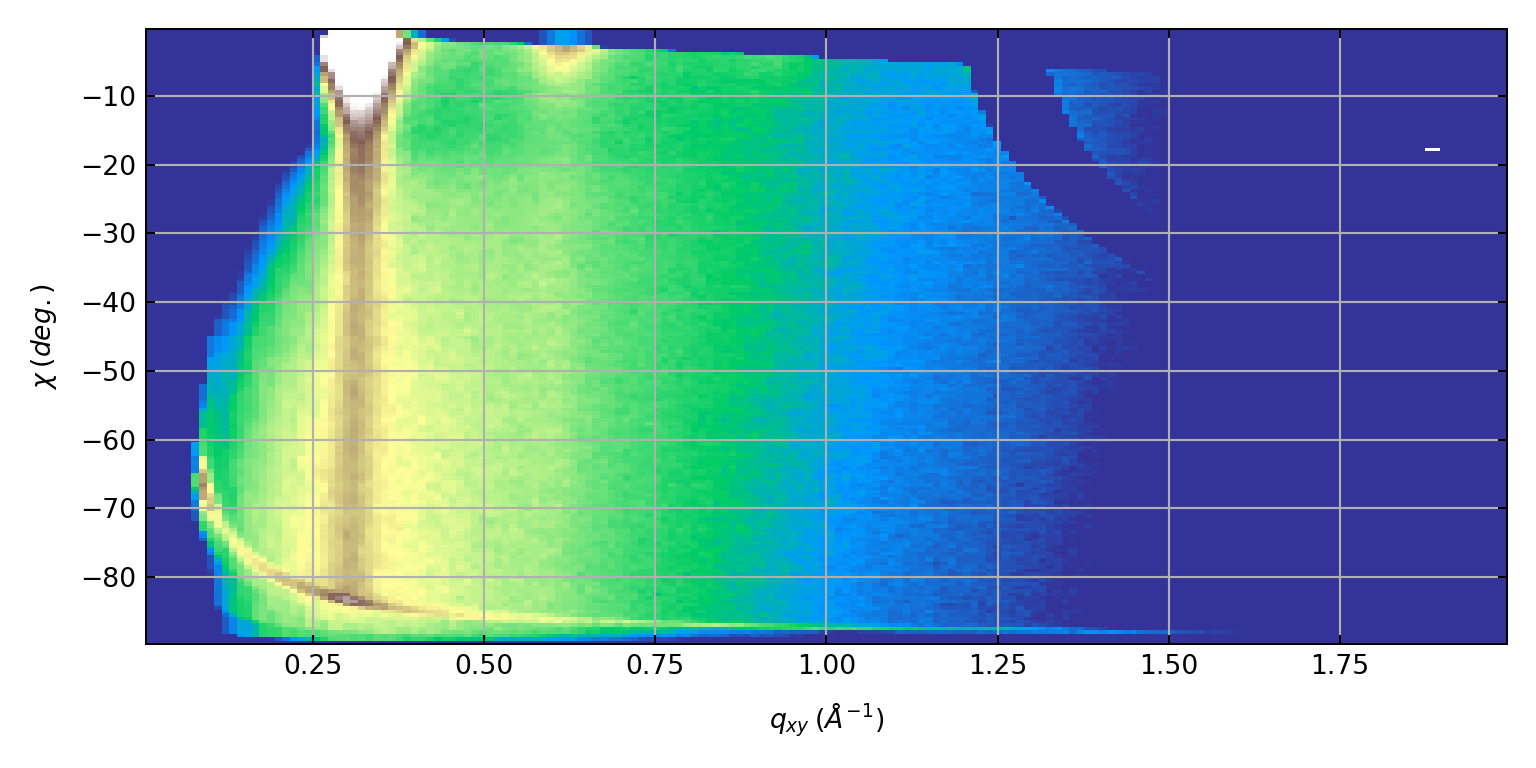

In [192]:
imgp, q_abs, chi = get_pole_figure(dfw, sample, os.path.join(nils_dir,'calib.csv'))
corrimg = imgp-np.min(imgp)+1
logimg = np.log(corrimg)

pcolor(logimg, figsize=(8,4),
       extent=[q_abs.min(), q_abs.max(), chi.min(), chi.max()],
       origin='lower', prcs=(40,99.5))
plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
plt.ylabel(r'$\chi \: (deg.)$')
plt.gca().grid(True)

## Let's add a blank

In [193]:
blank_files = glob.glob(os.path.join(nils_dir, 'blanks', '*.tiff'))
dfb = build_master_table(blank_files)
dfb

tiff        sample       t  \
0   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank  1010.9   
1   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank  1043.9   
2   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank  1077.0   
3   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   171.8   
4   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   175.9   
5   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   179.9   
6   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   183.9   
7   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   187.9   
8   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   637.0   
9   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   670.1   
10  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   703.0   
11  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   736.9   
12  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   771.0   
13  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   805.0   
14  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   912.1   
15  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   945.0   
16  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   978.0   
17  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5363.3   
18  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5383.3   
19  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5404.2   
20  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5425.2   
21  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5447.2   
22  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5373.2   
23  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5393.2   
24  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5414.2   
25  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5436.2   
26  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5458.2   
27  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si  1153.7   
28  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   232.7   
29  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   236.7   
30  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   240.6   
31  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   244.7   
32  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   248.7   
33  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   280.7   
34  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   293.7   
35  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   306.7   
36  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   319.7   
37  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   332.6   
38  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   373.7   
39  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   751.6   
40  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   807.6   
41  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   924.7   
42  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   959.7   
43  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1  1006.7   
44  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1   104.6   
45  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1   217.6   
46  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1    27.6   
47  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1   854.7   
48  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1   974.7   
49  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos2  1020.8   
50  /Users/nils/CC/C

## Define a function to make a transform with these parameters

In [194]:
sample=904
dfw.loc[sample]

tiff        /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...
burst                                                     NaN
exp_time                                                   10
mode                                                     maxs
sample                                      ds30cn_30_w1_pos1
stamp                                                  994732
t                                                       272.8
theta                                                    0.15
Name: 904, dtype: object

In [195]:
def get_blank(dfb,dfw,sample,blank_set='si_pos1'):
    """ Given a sample row from a regular df, find blank with corresponding theta and
    scale for exposure time"""
    
    dfb_filter = dfb.loc[dfb['sample']==blank_set].loc[dfb['mode']==dfw['mode'].loc[sample]]
    dfb_sorted = dfb_filter.iloc[(dfb_filter['theta']-dfw['theta'].loc[sample]).abs().argsort()]
    blank_match = dfb_sorted.index.values[0]
    blank_raw = get_data(dfb_sorted, blank_match)
    blank_scaled = blank_raw * dfw['exp_time'].loc[sample] / dfb['exp_time'].loc[blank_match]

    return blank_scaled

2019-02-26 08:04:58,107 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


<IPython.core.display.Javascript object>


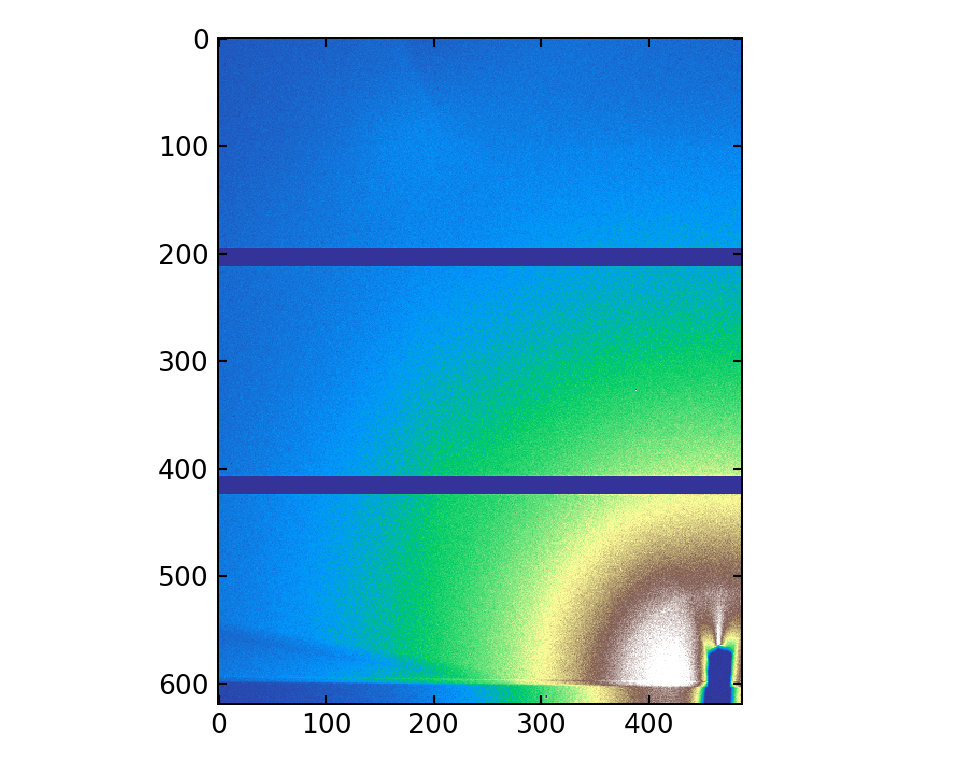

In [197]:
pcolor(get_blank(dfb,dfw,904, blank_set='si_pos1'), aspect='equal')

2019-02-26 08:05:11,655 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:05:11,691 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:05:11,717 - pygix.transform - INFO - pygix.Transform.transform_image: Resetting transformer because init


<IPython.core.display.Javascript object>


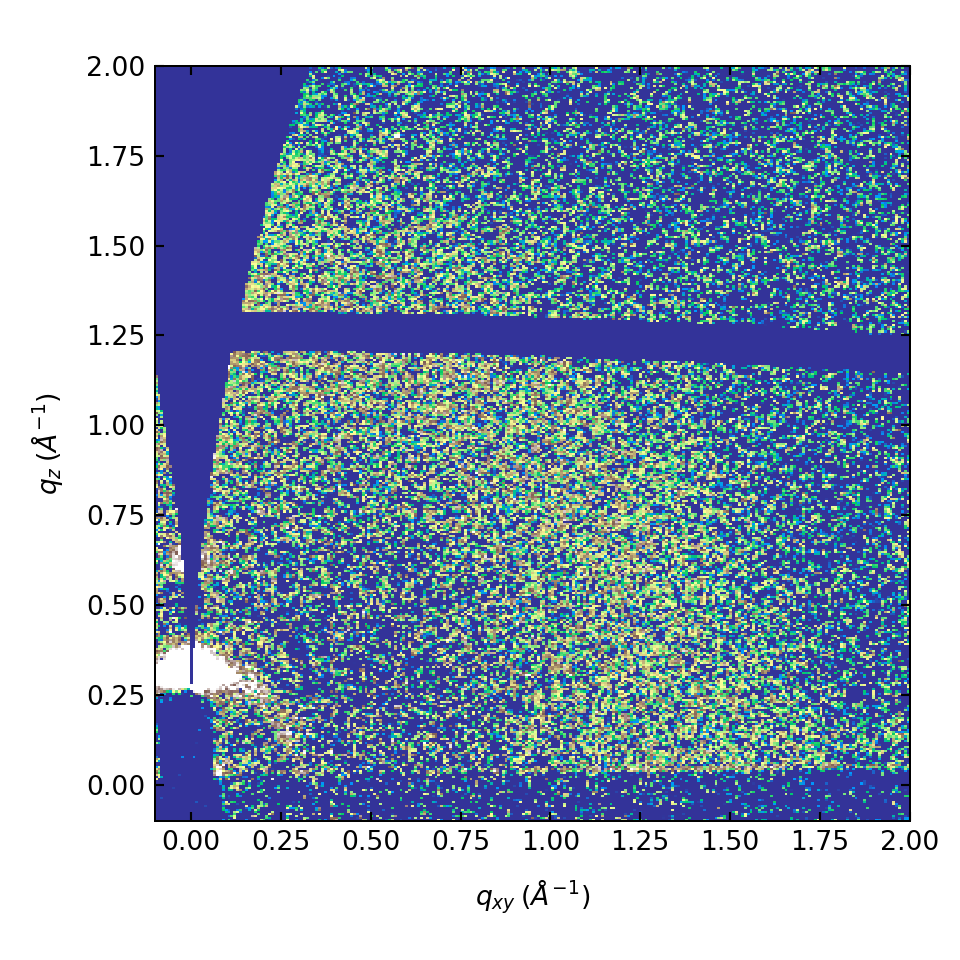

/anaconda/envs/pygix/lib/python3.6/site-packages/pygix-0.1.4a0-py3.6.egg/pygix/plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


In [199]:
samp = 800
show_sample(dfw, samp, dark=get_blank(dfb, dfw, samp, blank_set='si_pos1'))
# show_sample(dfw, samp)